## Introduction
-----

In this assignment you will recursively estimate the position of a vehicle along a trajectory using available measurements and a motion model. 

The vehicle is equipped with a very simple type of LIDAR sensor, which returns range and bearing measurements corresponding to individual landmarks in the environment. The global positions of the landmarks are assumed to be known beforehand. We will also assume known data association, that is, which measurment belong to which landmark.

## Motion and Measurement Models
-----

### Motion Model

The vehicle motion model recieves linear and angular velocity odometry readings as inputs, and outputs the state (i.e., the 2D pose) of the vehicle:

\begin{align}
\mathbf{x}_{k} &= \mathbf{x}_{k-1} + T
\begin{bmatrix}
\cos\theta_{k-1} &0 \\
\sin\theta_{k-1} &0 \\
0 &1
\end{bmatrix}
\left(
\begin{bmatrix}
v_k \\
\omega_k
\end{bmatrix}
+ \mathbf{w}_k
\right)
\, , \, \, \, \, \, \mathbf{w}_k = \mathcal{N}\left(\mathbf{0}, \mathbf{Q}\right)
\end{align}

- $\mathbf{x}_k = \left[ x \, y \, \theta \right]^T$ is the current 2D pose of the vehicle
- $v_k$ and $\omega_k$ are the linear and angular velocity odometry readings, which we use as inputs to the model

The process noise $\mathbf{w}_k$ has a (zero mean) normal distribution with a constant covariance $\mathbf{Q}$.

### Measurement Model

The measurement model relates the current pose of the vehicle to the LIDAR range and bearing measurements $\mathbf{y}^l_k = \left[r \, \phi \right]^T$.

\begin{align}
\mathbf{y}^l_k =
\begin{bmatrix}
\sqrt{(x_l - x_k - d\cos\theta_{k})^2 + (y_l - y_k - d\sin\theta_{k})^2} \\
atan2\left(y_l - y_k - d\sin\theta_{k},x_l - x_k - d\cos\theta_{k}\right) - \theta_k
\end{bmatrix}
+
\mathbf{n}^l_k
\, , \, \, \, \, \, \mathbf{n}^l_k = \mathcal{N}\left(\mathbf{0}, \mathbf{R}\right)
\end{align}

- $x_l$ and $y_l$ are the ground truth coordinates of the landmark $l$
- $x_k$ and $y_k$ and $\theta_{k}$ represent the current pose of the vehicle
- $d$ is the known distance between robot center and laser rangefinder (LIDAR)

The landmark measurement noise $\mathbf{n}^l_k$ has a (zero mean) normal distribution with a constant covariance $\mathbf{R}$.

## Getting Started
-----

Since the models above are nonlinear, we recommend using the extended Kalman filter (EKF) as the state estimator.
Specifically, you will need to provide code implementing the following steps:
- the prediction step, which uses odometry measurements and the motion model to produce a state and covariance estimate at a given timestep, and
- the correction step, which uses the range and bearing measurements provided by the LIDAR to correct the pose and pose covariance estimates

### Unpack the Data
First, let's unpack the available data:

In [20]:
from math import cos, sin, sqrt, atan2
import pickle
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

with open('data/data.pickle', 'rb') as f:
    data = pickle.load(f)

t = data['t']  # timestamps [s]

x_init  = data['x_init'] # initial x position [m]
y_init  = data['y_init'] # initial y position [m]
th_init = data['th_init'] # initial theta position [rad]

# input signal
v  = data['v']  # translational velocity input [m/s]
om = data['om']  # rotational velocity input [rad/s]

# bearing and range measurements, LIDAR constants
b = data['b']  # bearing to each landmarks center in the frame attached to the laser [rad]
r = data['r']  # range measurements [m]
l = data['l']  # x,y positions of landmarks [m]
d = data['d']  # distance between robot center and laser rangefinder [m]

In [21]:
t[len(t) -1]

500

In [22]:
d[0]

0

In [23]:
d.shape

Note that distance from the LIDAR frame to the robot center is provided and loaded as an array into the `d` variable.

### Ground Truth
If available, it is useful to plot the ground truth position and orientation before starting the assignment.

<table><tr>
<td> <img src="data/gtruth.png" alt="Ground Truth" width="350"/> </td>
<td> <img src="data/gtruth2.png" alt="Ground Truth" width="350"/> </td>
</tr></table>

Notice that the orientation values are wrapped to the $\left[-\pi,\pi\right]$ range in radians.

### Initializing Parameters

Now that our data is loaded, we can begin getting things set up for our solver. One of the
most important aspects of designing a filter is determining the input and measurement noise covariance matrices, as well as the initial state and covariance values. We set the values here:

In [39]:
v_var = 0.01  # translation velocity variance  
om_var = 0.01  # rotational velocity variance 
r_var = 0.1  # range measurements variance
b_var = 0.1  # bearing measurement variance

r_var = 0.01
# b_var = 0.1  # bearing measurement variance
b_var = 5

Q_km = np.diag([v_var, om_var]) # input noise covariance 
cov_y = np.diag([r_var, b_var])  # measurement noise covariance 

x_est = np.zeros([len(v), 3])  # estimated states, x, y, and theta
P_est = np.zeros([len(v), 3, 3])  # state covariance matrices

x_est[0] = np.array([x_init, y_init, th_init]) # initial state
P_est[0] = np.diag([1, 1, 0.1]) # initial state covariance

**Remember:** that it is neccessary to tune the measurement noise variances `r_var`, `b_var` in order for the filter to perform well!

In order for the orientation estimates to coincide with the bearing measurements, it is also neccessary to wrap all estimated $\theta$ values to the $(-\pi , \pi]$ range.

In [40]:
# Dimensions of Q and cov_y checking
print(Q_km.shape)
print(cov_y.shape)
print(x_est.shape)
print(x_est[0, :])

(2, 2)
(2, 2)
(501, 3)
[50.          0.          1.57079633]


In [41]:
# Wraps angle to (-pi,pi] range
def wraptopi(x):
    if x > np.pi:
        x = x - (np.floor(x / (2 * np.pi)) + 1) * 2 * np.pi
    elif x < -np.pi:
        x = x + (np.floor(x / (-2 * np.pi)) + 1) * 2 * np.pi
    return x


## Correction Step
-----
First, let's implement the measurement update function, which takes an available landmark measurement $l$ and updates the current state estimate $\mathbf{\check{x}}_k$.
For each landmark measurement received at a given timestep $k$, you should implement the following steps:

- Compute the measurement model Jacobians at $\mathbf{\check{x}}_{k}$
\begin{align}
\mathbf{y}^l_k = &\mathbf{h}(\mathbf{x}_{k}, \mathbf{n}^l_k) \\\\
\mathbf{H}_{k} = \frac{\partial \mathbf{h}}{\partial \mathbf{x}_{k}}\bigg|_{\mathbf{\check{x}}_{k},0}& \, , \, \, \, \,
\mathbf{M}_{k} = \frac{\partial \mathbf{h}}{\partial \mathbf{n}_{k}}\bigg|_{\mathbf{\check{x}}_{k},0} \, .
\end{align}
- Compute the Kalman Gain
\begin{align}
\mathbf{K}_k &= \mathbf{\check{P}}_k \mathbf{H}_k^T \left(\mathbf{H}_k \mathbf{\check{P}}_k \mathbf{H}_k^T + \mathbf{M}_k \mathbf{R}_k \mathbf{M}_k^T \right)^{-1} 
\end{align}
- Correct the predicted state
\begin{align}
\mathbf{\check{y}}^l_k &= \mathbf{h}\left(\mathbf{\check{x}}_k, \mathbf{0}\right) \\
\mathbf{\hat{x}}_k &= \mathbf{\check{x}}_k + \mathbf{K}_k \left(\mathbf{y}^l_k - \mathbf{\check{y}}^l_k\right)
\end{align}
- Correct the covariance
\begin{align}
\mathbf{\hat{P}}_k &= \left(\mathbf{I} - \mathbf{K}_k \mathbf{H}_k \right)\mathbf{\check{P}}_k
\end{align}

In [42]:
# Use of sympy jacobian function to get Jacobian equation for Measurement Model
import sympy as sp
from sympy import *

# our d[0] = 0 and we want to exploit it's usage
# Define the symbols
x, y, theta, lx, ly = sp.symbols('x y theta lx ly')

# Define the state vector
x_k = sp.Matrix([[x],[y],[theta]])

# Define the measurement model
y_k = sp.Matrix([[sp.sqrt(((lx -x)**2) + ((ly - y)**2))],
                 [sp.atan2((ly - y), (lx - x)) - theta]])

In [43]:
Hk = y_k.jacobian(x_k)
Hk

⎡         -lx + x                     -ly + y              ⎤
⎢──────────────────────────  ──────────────────────────  0 ⎥
⎢   _______________________     _______________________    ⎥
⎢  ╱         2           2     ╱         2           2     ⎥
⎢╲╱  (lx - x)  + (ly - y)    ╲╱  (lx - x)  + (ly - y)      ⎥
⎢                                                          ⎥
⎢       -(-ly + y)                   -(lx - x)             ⎥
⎢  ─────────────────────       ─────────────────────     -1⎥
⎢          2           2               2           2       ⎥
⎣  (lx - x)  + (ly - y)        (lx - x)  + (ly - y)        ⎦

In [44]:
# Define the noise variables
r_var, b_var = sp.symbols('r_var b_var')

# Define the measurement model with noise
y_k_noise = y_k + sp.Matrix([[r_var], [b_var]])

# Compute the Jacobian with respect to the noise
M = y_k_noise.jacobian(sp.Matrix([r_var, b_var]))

M

⎡1  0⎤
⎢    ⎥
⎣0  1⎦

In [45]:
def measurement_update(lk, rk, bk, P_check, x_check):

    # Define the measurement model
    # our d[0] = 0 and we want to exploit it's usage
    ## NOTE: H_k will be 2 * 3 and M_k will be 2 * 2

    # Define the symbols
    x, y, theta, lx, ly = sp.symbols('x y theta lx ly')

    # Define the state vector
    x_k = sp.Matrix([x, y, theta])

    # Define the measurement model
    y_k = sp.Matrix([sp.sqrt((lx -x)**2 + (ly - y)**2),
                     sp.atan2((ly - y), (lx - x)) - theta])
    
    """
    # Substitute the actual values of the symbols into the symbolic matrices
    x_k_val = x_k.subs({x: x_check[0], y: x_check[1], theta: x_check[2]})
    y_k_val = y_k.subs({x: x_check[0], y: x_check[1], theta: x_check[2], lx: lk[0], ly: lk[1]})

    # Convert the symbolic matrices to numpy arrays
    x_k_np = np.array(x_k_val.tolist()).astype(float64)
    y_k_np = np.array(y_k_val.tolist()).astype(float64)
    """

    # Compute the Jacobian
    H_k = y_k.jacobian(x_k)

    # Define a function that takes in the values of x, y, theta, lx, and ly
    f = sp.lambdify((x, y, theta, lx, ly), H_k)

    # Call the function with the actual values of x, y, theta, lx, and ly
    H_k = f(x_check[0], x_check[1], x_check[2], lk[0], lk[1])

    # Convert the result to a numpy array and ensure it has the correct data type
    H_k = np.array(H_k).astype(np.float64)
    
    #print("H_k shape", H_k.shape)

    #M = np.zeros((2, 2))
    M = np.diag((1.0, 1.0))
    
    # 2. Compute Kalman Gain
    """
    inv_k = np.linalg.inv(np.linalg.multi_dot([H_k, P_check, H_k.T]) + np.linalg.multi_dot([M, cov_y, M.T]))
    K = np.dot(np.dot(P_check, H_k.T), inv_k)
    """

    #K = np.dot(P_check, np.dot(H_k.T, np.linalg.inv(np.linalg.multi_dot([H_k,P_check,H_k.T]) + 
                                              # np.linalg.multi_dot([M,cov_y,M.T])))) #3x2 matrix
    #K = P_check.dot(H_k.T).dot(np.linalg.inv(np.linalg.multi_dot([H_k,P_check,H_k.T]) + 
     #                                          np.linalg.multi_dot([M,cov_y,M.T])))
    # Convert the arrays to a numerical type
    P_check = P_check.astype(np.float64)
    H_k = H_k.astype(np.float64)
    M = M.astype(np.float64)
    #cov_y = cov_y.astype(np.float64)

    # Now perform the matrix multiplication
    K = P_check @ H_k.T @ inv(H_k @ P_check @ H_k.T + M @ cov_y @ M.T)
    #K = np.ones((3,2))
    

    
    # 3. Correct predicted state (remember to wrap the angles to [-pi,pi])
    # We need to implement xhat_k = xcap_k + K (z_k - h_k(xcap_k, 0))
    # h_k(xcap_k, 0) serve as estimated value

    # Compute the range
    range_val = np.sqrt((lk[0] - x_check[0])**2 + (lk[1] - x_check[1])**2)
    # Compute the bearing
    bearing_val = np.arctan2((lk[1] - x_check[1]), (lk[0] - x_check[0])) - x_check[2]
    # Combine range and bearing into a numpy array
    h_k_val = np.array([range_val, bearing_val])
    h_k_val[1] = wraptopi(h_k_val[1])
    #print("h_k_val shape", h_k_val.shape)
   
    
    # z_k serve as actual/real value coming from range and bearing from Lidar pc.
    #z_k = np.array([rk, wraptopi(bk)]) # shape (2,)
    z_k = np.array([rk, wraptopi(bk)]).reshape((2, 1))
    #print("z_k shape", z_k.shape)
    
    #x_check += np.dot(K, z_k - h_k_val) # Keep an eye on the dimensions of each value
    #print("state shape",x_check.shape) # (3, 1)
    #print("z_k - hk shape",(z_k - h_k_val).shape) # it's 2*2, k(3,2) * diff(2*2) = res(3*2) but it should be 3*1
    x_check += np.dot(K, z_k - h_k_val)
    
    
    # 4. Correct covariance
    P_check = np.dot((np.identity(3) - np.dot(K, H_k)), P_check)
    
    return x_check, P_check


## Prediction Step
-----
Now, implement the main filter loop, defining the prediction step of the EKF using the motion model provided:

\begin{align}
\mathbf{\check{x}}_k &= \mathbf{f}\left(\mathbf{\hat{x}}_{k-1}, \mathbf{u}_{k-1}, \mathbf{0} \right) \\
\mathbf{\check{P}}_k &= \mathbf{F}_{k-1}\mathbf{\hat{P}}_{k-1}\mathbf{F}_{k-1}^T + \mathbf{L}_{k-1}\mathbf{Q}_{k-1}\mathbf{L}_{k-1}^T \, .
\end{align}

Where

\begin{align}
\mathbf{F}_{k-1} = \frac{\partial \mathbf{f}}{\partial \mathbf{x}_{k-1}}\bigg|_{\mathbf{\hat{x}}_{k-1},\mathbf{u}_{k},0}  \, , \, \, \, \,
\mathbf{L}_{k-1} = \frac{\partial \mathbf{f}}{\partial \mathbf{w}_{k}}\bigg|_{\mathbf{\hat{x}}_{k-1},\mathbf{u}_{k},0} \, .
\end{align}

In [46]:
P_check = P_est[0]
P_check
x_check = [x_est[0, 0], x_est[0, 1], wraptopi(x_est[0, 2])]
x_check

In [47]:
# Use of sympy jacobian function to get Jacobian equation for motion model
import sympy as sp
from sympy import *

x1, y1, d, x, y, theta, T, v_k, om_k, w_k, Q = symbols('x1 y1 d x y theta_k-1 T v_k om_k w_k Q')
sp.init_printing(use_latex = True)

state = sp.Matrix([x, y, theta])
X_k = sp.Matrix([[x], [y], [theta]]) + T * sp.Matrix([[cos(theta), 0], [sin(theta), 0], [0, 1]])@(sp.Matrix([[v_k], [om_k]]))
X_k

⎡T⋅vₖ⋅cos(θₖ₋₁) + x⎤
⎢                  ⎥
⎢T⋅vₖ⋅sin(θₖ₋₁) + y⎥
⎢                  ⎥
⎣   T⋅omₖ + θₖ₋₁   ⎦

In [48]:
F = X_k.jacobian(state)
F

⎡1  0  -T⋅vₖ⋅sin(θₖ₋₁)⎤
⎢                     ⎥
⎢0  1  T⋅vₖ⋅cos(θₖ₋₁) ⎥
⎢                     ⎥
⎣0  0         1       ⎦

In [49]:
# Define the actual velocities
v_k, om_k = symbols('v_k om_k')

# Define X_k for F
X_k_F = sp.Matrix([[x], [y], [theta]]) + T * sp.Matrix([[cos(theta), 0], [sin(theta), 0], [0, 1]])@(sp.Matrix([[v_k], [om_k]]))

# Define the noise variables
v_var, om_var = symbols('v_var om_var')

# Define X_k for L
X_k_L = sp.Matrix([[x], [y], [theta]]) + T * sp.Matrix([[cos(theta), 0], [sin(theta), 0], [0, 1]])@(sp.Matrix([[v_var], [om_var]]))
L = X_k_L.jacobian(sp.Matrix([v_var, om_var]))

In [50]:
L

⎡T⋅cos(θₖ₋₁)  0⎤
⎢              ⎥
⎢T⋅sin(θₖ₋₁)  0⎥
⎢              ⎥
⎣     0       T⎦

In [51]:
#### 5. Main Filter Loop #######################################################################
x_check = x_est[0, :].reshape(3,1)
P_check = P_est[0] 
for k in range(1, len(t)):  # start at 1 because we've set the initial prediciton

    delta_t = t[k] - t[k - 1]  # time step (difference between timestamps)
    theta = wraptopi(x_check[2])
    theta = x_check[2]

    # 1. Update state with odometry readings (remember to wrap the angles to [-pi,pi])
    #x_check = np.zeros([3,1])
    x_check[0] += v[k-1] * np.cos(theta) * delta_t
    x_check[1] += v[k-1] * np.sin(theta) * delta_t
    x_check[2] += om[k-1] * delta_t
    x_check[2] = wraptopi(x_check[2])
    
    # 2. Motion model jacobian with respect to last state
        # Use X_k.jacobian(state) equation
    F_km = np.array([[1, 0, -v[k-1] * np.sin(theta) * delta_t],
                     [0, 1, v[k-1] * np.cos(theta) * delta_t],
                     [0, 0, 1]])

    # 3. Motion model jacobian with respect to noise
        #  Use X_k_L.jacobian(sp.Matrix([v_var, om_var])) equation
    L_km = np.array([[np.cos(theta) * delta_t, 0],
                     [np.sin(theta) * delta_t, 0],
                     [0, delta_t]])

    # 4. Propagate uncertainty
    P_check = np.linalg.multi_dot([F_km,P_est[k-1],F_km.T]) + np.linalg.multi_dot([L_km,Q_km,L_km.T])
    # 5. Update state estimate using available landmark measurements
    for i in range(len(r[k])):
        print("x_predict :", x_check)
        x_check, P_check = measurement_update(l[i], r[k, i], b[k, i], P_check, x_check)
        print("x_hat : ", x_check)
        #print("-----------------------------")
        
    # Set final state predictions for timestep
    x_est[k, 0] = x_check[0]
    x_est[k, 1] = x_check[1]
    x_est[k, 2] = x_check[2]
    P_est[k, :, :] = P_check

x_predict : [[50.        ]
 [ 0.68107866]
 [ 1.69990024]]
x_hat :  [[49.98048633]
 [ 0.68123288]
 [ 1.69942207]]
x_predict : [[49.98048633]
 [ 0.68123288]
 [ 1.69942207]]
x_hat :  [[49.9807231]
 [ 0.681274 ]
 [ 1.6977204]]
x_predict : [[49.9807231]
 [ 0.681274 ]
 [ 1.6977204]]
x_hat :  [[49.98172012]
 [ 0.63524744]
 [ 1.69633765]]
x_predict : [[49.98172012]
 [ 0.63524744]
 [ 1.69633765]]
x_hat :  [[49.98133263]
 [ 0.63469109]
 [ 1.69478954]]
x_predict : [[49.98133263]
 [ 0.63469109]
 [ 1.69478954]]
x_hat :  [[49.98154856]
 [ 0.63409239]
 [ 1.69326437]]
x_predict : [[49.98154856]
 [ 0.63409239]
 [ 1.69326437]]
x_hat :  [[49.98081918]
 [ 0.63207345]
 [ 1.69185966]]
x_predict : [[49.98081918]
 [ 0.63207345]
 [ 1.69185966]]
x_hat :  [[49.9806066 ]
 [ 0.61891768]
 [ 1.69053562]]
x_predict : [[49.9806066 ]
 [ 0.61891768]
 [ 1.69053562]]
x_hat :  [[49.9803093 ]
 [ 0.61907889]
 [ 1.68919202]]
x_predict : [[49.89804128]
 [ 1.31068562]
 [ 1.75655769]]
x_hat :  [[49.98457522]
 [ 1.32581088]
 [ 1.

x_hat :  [[49.57752009]
 [ 6.15434322]
 [ 1.97713299]]
x_predict : [[49.57752009]
 [ 6.15434322]
 [ 1.97713299]]
x_hat :  [[49.57753218]
 [ 6.15447257]
 [ 1.97627416]]
x_predict : [[49.57753218]
 [ 6.15447257]
 [ 1.97627416]]
x_hat :  [[49.57305414]
 [ 6.16237108]
 [ 1.97779794]]
x_predict : [[49.57305414]
 [ 6.16237108]
 [ 1.97779794]]
x_hat :  [[49.57479362]
 [ 6.16772309]
 [ 1.97299779]]
x_predict : [[49.57479362]
 [ 6.16772309]
 [ 1.97299779]]
x_hat :  [[49.57288625]
 [ 6.16556213]
 [ 1.9910637 ]]
x_predict : [[49.57288625]
 [ 6.16556213]
 [ 1.9910637 ]]
x_hat :  [[49.57071601]
 [ 6.16736923]
 [ 1.99209768]]
x_predict : [[49.29999854]
 [ 6.77146816]
 [ 2.02865461]]
x_hat :  [[49.41374026]
 [ 6.81135251]
 [ 1.89809945]]
x_predict : [[49.41374026]
 [ 6.81135251]
 [ 1.89809945]]
x_hat :  [[49.45273955]
 [ 6.8103216 ]
 [ 1.85908815]]
x_predict : [[49.45273955]
 [ 6.8103216 ]
 [ 1.85908815]]
x_hat :  [[49.46924819]
 [ 6.78510033]
 [ 1.85225174]]
x_predict : [[49.46924819]
 [ 6.78510033]

x_hat :  [[48.56915516]
 [11.51517984]
 [ 1.95437801]]
x_predict : [[48.56915516]
 [11.51517984]
 [ 1.95437801]]
x_hat :  [[48.56812396]
 [11.51616858]
 [ 1.95496508]]
x_predict : [[48.30680389]
 [12.16259306]
 [ 1.84223653]]
x_hat :  [[48.33988774]
 [12.18159938]
 [ 1.80231524]]
x_predict : [[48.33988774]
 [12.18159938]
 [ 1.80231524]]
x_hat :  [[48.36612181]
 [12.17853282]
 [ 1.77567113]]
x_predict : [[48.36612181]
 [12.17853282]
 [ 1.77567113]]
x_hat :  [[48.37546993]
 [12.18036493]
 [ 1.7656178 ]]
x_predict : [[48.37546993]
 [12.18036493]
 [ 1.7656178 ]]
x_hat :  [[48.38118202]
 [12.18120941]
 [ 1.75964858]]
x_predict : [[48.38118202]
 [12.18120941]
 [ 1.75964858]]
x_hat :  [[48.39959519]
 [12.15219664]
 [ 1.74832642]]
x_predict : [[48.39959519]
 [12.15219664]
 [ 1.74832642]]
x_hat :  [[48.39824404]
 [12.14303644]
 [ 1.75243467]]
x_predict : [[48.39824404]
 [12.14303644]
 [ 1.75243467]]
x_hat :  [[48.41196477]
 [12.09753878]
 [ 1.73609578]]
x_predict : [[48.41196477]
 [12.09753878]

x_predict : [[46.70606702]
 [16.58336065]
 [ 2.14526609]]
x_hat :  [[46.70646134]
 [16.58687792]
 [ 2.142086  ]]
x_predict : [[46.70646134]
 [16.58687792]
 [ 2.142086  ]]
x_hat :  [[46.70232108]
 [16.58846898]
 [ 2.14551505]]
x_predict : [[46.70232108]
 [16.58846898]
 [ 2.14551505]]
x_hat :  [[46.69240026]
 [16.59964862]
 [ 2.14931509]]
x_predict : [[46.69240026]
 [16.59964862]
 [ 2.14931509]]
x_hat :  [[46.69264046]
 [16.6009111 ]
 [ 2.14782865]]
x_predict : [[46.69264046]
 [16.6009111 ]
 [ 2.14782865]]
x_hat :  [[46.69342325]
 [16.59920729]
 [ 2.14767852]]
x_predict : [[46.69342325]
 [16.59920729]
 [ 2.14767852]]
x_hat :  [[46.68845937]
 [16.60336598]
 [ 2.15032514]]
x_predict : [[46.42424815]
 [17.00705299]
 [ 2.2846919 ]]
x_hat :  [[46.46720705]
 [17.03453866]
 [ 2.21628045]]
x_predict : [[46.46720705]
 [17.03453866]
 [ 2.21628045]]
x_hat :  [[46.48803409]
 [17.02847707]
 [ 2.1987241 ]]
x_predict : [[46.48803409]
 [17.02847707]
 [ 2.1987241 ]]
x_hat :  [[46.49029701]
 [17.05791666]

x_hat :  [[44.41106816]
 [20.38489268]
 [ 2.26847176]]
x_predict : [[44.41106816]
 [20.38489268]
 [ 2.26847176]]
x_hat :  [[44.41066584]
 [20.38350651]
 [ 2.27009989]]
x_predict : [[44.41066584]
 [20.38350651]
 [ 2.27009989]]
x_hat :  [[44.40979325]
 [20.3851596 ]
 [ 2.26967886]]
x_predict : [[44.40979325]
 [20.3851596 ]
 [ 2.26967886]]
x_hat :  [[44.40497419]
 [20.38831223]
 [ 2.27269114]]
x_predict : [[44.06166883]
 [20.79433483]
 [ 2.29181544]]
x_hat :  [[44.06326965]
 [20.79593774]
 [ 2.28886266]]
x_predict : [[44.06326965]
 [20.79593774]
 [ 2.28886266]]
x_hat :  [[44.07264567]
 [20.79419543]
 [ 2.28091316]]
x_predict : [[44.07264567]
 [20.79419543]
 [ 2.28091316]]
x_hat :  [[44.07567638]
 [20.78098295]
 [ 2.28867326]]
x_predict : [[44.07567638]
 [20.78098295]
 [ 2.28867326]]
x_hat :  [[44.0801181 ]
 [20.78004588]
 [ 2.28499649]]
x_predict : [[44.0801181 ]
 [20.78004588]
 [ 2.28499649]]
x_hat :  [[44.0855077 ]
 [20.77638625]
 [ 2.28261029]]
x_predict : [[44.0855077 ]
 [20.77638625]

x_hat :  [[41.20306188]
 [23.27731016]
 [ 2.52297496]]
x_predict : [[41.20306188]
 [23.27731016]
 [ 2.52297496]]
x_hat :  [[41.19570129]
 [23.2786616 ]
 [ 2.52867073]]
x_predict : [[41.19570129]
 [23.2786616 ]
 [ 2.52867073]]
x_hat :  [[41.18311065]
 [23.28505902]
 [ 2.532785  ]]
x_predict : [[41.18311065]
 [23.28505902]
 [ 2.532785  ]]
x_hat :  [[41.18426943]
 [23.2875002 ]
 [ 2.52858588]]
x_predict : [[41.18426943]
 [23.2875002 ]
 [ 2.52858588]]
x_hat :  [[41.17711249]
 [23.29821764]
 [ 2.52163443]]
x_predict : [[41.17711249]
 [23.29821764]
 [ 2.52163443]]
x_hat :  [[41.16998645]
 [23.30182812]
 [ 2.52406273]]
x_predict : [[40.77625465]
 [23.58145115]
 [ 2.7010099 ]]
x_hat :  [[40.80141246]
 [23.60737591]
 [ 2.65372546]]
x_predict : [[40.80141246]
 [23.60737591]
 [ 2.65372546]]
x_hat :  [[40.82840136]
 [23.6038688 ]
 [ 2.64046661]]
x_predict : [[40.82840136]
 [23.6038688 ]
 [ 2.64046661]]
x_hat :  [[40.82300763]
 [23.61635555]
 [ 2.6289297 ]]
x_predict : [[40.82300763]
 [23.61635555]

x_hat :  [[37.72136221]
 [24.8169465 ]
 [ 2.77244639]]
x_predict : [[37.72136221]
 [24.8169465 ]
 [ 2.77244639]]
x_hat :  [[37.71926841]
 [24.81232062]
 [ 2.77965057]]
x_predict : [[37.71926841]
 [24.81232062]
 [ 2.77965057]]
x_hat :  [[37.72371238]
 [24.80578411]
 [ 2.78506706]]
x_predict : [[37.72371238]
 [24.80578411]
 [ 2.78506706]]
x_hat :  [[37.72581316]
 [24.80489099]
 [ 2.78515086]]
x_predict : [[37.36199392]
 [24.94035761]
 [ 2.67969925]]
x_hat :  [[37.33226208]
 [24.90023576]
 [ 2.75197147]]
x_predict : [[37.33226208]
 [24.90023576]
 [ 2.75197147]]
x_hat :  [[37.29983468]
 [24.90549166]
 [ 2.76773919]]
x_predict : [[37.29983468]
 [24.90549166]
 [ 2.76773919]]
x_hat :  [[37.32090285]
 [24.87431688]
 [ 2.79356847]]
x_predict : [[37.32090285]
 [24.87431688]
 [ 2.79356847]]
x_hat :  [[37.30568872]
 [24.87458697]
 [ 2.80384279]]
x_predict : [[37.30568872]
 [24.87458697]
 [ 2.80384279]]
x_hat :  [[37.29778223]
 [24.87709837]
 [ 2.80630074]]
x_predict : [[37.29778223]
 [24.87709837]

x_hat :  [[33.3655787 ]
 [24.8816492 ]
 [-2.97007082]]
x_predict : [[33.3655787 ]
 [24.8816492 ]
 [-2.97007082]]
x_hat :  [[33.33155053]
 [24.88005164]
 [-2.97226577]]
x_predict : [[33.33155053]
 [24.88005164]
 [-2.97226577]]
x_hat :  [[33.33663674]
 [24.87392162]
 [-2.9635943 ]]
x_predict : [[33.33663674]
 [24.87392162]
 [-2.9635943 ]]
x_hat :  [[33.32380935]
 [24.87154571]
 [-2.9621342 ]]
x_predict : [[33.32380935]
 [24.87154571]
 [-2.9621342 ]]
x_hat :  [[33.31762753]
 [24.87227667]
 [-2.96394251]]
x_predict : [[33.31762753]
 [24.87227667]
 [-2.96394251]]
x_hat :  [[33.31490808]
 [24.86700619]
 [-2.95745017]]
x_predict : [[33.31490808]
 [24.86700619]
 [-2.95745017]]
x_hat :  [[33.31694023]
 [24.864096  ]
 [-2.95349669]]
x_predict : [[33.31694023]
 [24.864096  ]
 [-2.95349669]]
x_hat :  [[33.31482416]
 [24.86465687]
 [-2.95459533]]
x_predict : [[32.84531366]
 [24.77582178]
 [-2.94886216]]
x_hat :  [[32.83773847]
 [24.76495529]
 [-2.93712578]]
x_predict : [[32.83773847]
 [24.76495529]

x_hat :  [[28.90724742]
 [23.56633097]
 [-2.81667787]]
x_predict : [[28.90724742]
 [23.56633097]
 [-2.81667787]]
x_hat :  [[28.90268336]
 [23.5665481 ]
 [-2.81862785]]
x_predict : [[28.90268336]
 [23.5665481 ]
 [-2.81862785]]
x_hat :  [[28.90290285]
 [23.56701938]
 [-2.81885446]]
x_predict : [[28.90290285]
 [23.56701938]
 [-2.81885446]]
x_hat :  [[28.89893446]
 [23.57306749]
 [-2.82685944]]
x_predict : [[28.89893446]
 [23.57306749]
 [-2.82685944]]
x_hat :  [[28.89686094]
 [23.57350328]
 [-2.82797169]]
x_predict : [[28.37536685]
 [23.40436988]
 [-2.79735707]]
x_hat :  [[28.37607877]
 [23.40566159]
 [-2.7982344 ]]
x_predict : [[28.37607877]
 [23.40566159]
 [-2.7982344 ]]
x_hat :  [[28.38507626]
 [23.40649585]
 [-2.79547229]]
x_predict : [[28.38507626]
 [23.40649585]
 [-2.79547229]]
x_hat :  [[28.37605313]
 [23.41523066]
 [-2.80794442]]
x_predict : [[28.37605313]
 [23.41523066]
 [-2.80794442]]
x_hat :  [[28.38001079]
 [23.41654285]
 [-2.80758238]]
x_predict : [[28.38001079]
 [23.41654285]

x_hat :  [[24.08296537]
 [21.17116659]
 [-2.79659067]]
x_predict : [[24.08296537]
 [21.17116659]
 [-2.79659067]]
x_hat :  [[24.08848065]
 [21.16262165]
 [-2.78577695]]
x_predict : [[24.08848065]
 [21.16262165]
 [-2.78577695]]
x_hat :  [[24.09219947]
 [21.16160177]
 [-2.78323929]]
x_predict : [[23.49844607]
 [20.93922683]
 [-2.89824428]]
x_hat :  [[23.48436734]
 [20.84695313]
 [-2.80888263]]
x_predict : [[23.48436734]
 [20.84695313]
 [-2.80888263]]
x_hat :  [[23.48787371]
 [20.84714158]
 [-2.80756574]]
x_predict : [[23.48787371]
 [20.84714158]
 [-2.80756574]]
x_hat :  [[23.51978128]
 [20.82434215]
 [-2.77645431]]
x_predict : [[23.51978128]
 [20.82434215]
 [-2.77645431]]
x_hat :  [[23.5156652 ]
 [20.82216737]
 [-2.77476614]]
x_predict : [[23.5156652 ]
 [20.82216737]
 [-2.77476614]]
x_hat :  [[23.51903515]
 [20.82146845]
 [-2.77270112]]
x_predict : [[23.51903515]
 [20.82146845]
 [-2.77270112]]
x_hat :  [[23.51647385]
 [20.81009132]
 [-2.76159118]]
x_predict : [[23.51647385]
 [20.81009132]

x_hat :  [[18.41621573]
 [17.07990003]
 [-2.23289258]]
x_predict : [[18.41621573]
 [17.07990003]
 [-2.23289258]]
x_hat :  [[18.42132304]
 [17.08319297]
 [-2.23104632]]
x_predict : [[18.42132304]
 [17.08319297]
 [-2.23104632]]
x_hat :  [[18.42040682]
 [17.08368153]
 [-2.2326305 ]]
x_predict : [[18.42040682]
 [17.08368153]
 [-2.2326305 ]]
x_hat :  [[18.42236366]
 [17.09430897]
 [-2.23703908]]
x_predict : [[18.42236366]
 [17.09430897]
 [-2.23703908]]
x_hat :  [[18.4166038 ]
 [17.10332209]
 [-2.24678682]]
x_predict : [[18.4166038 ]
 [17.10332209]
 [-2.24678682]]
x_hat :  [[18.41722532]
 [17.10320356]
 [-2.24678563]]
x_predict : [[17.9764559 ]
 [16.55364959]
 [-2.0755268 ]]
x_hat :  [[17.9707633 ]
 [16.60751077]
 [-2.1066921 ]]
x_predict : [[17.9707633 ]
 [16.60751077]
 [-2.1066921 ]]
x_hat :  [[17.9014576 ]
 [16.58700381]
 [-2.15993513]]
x_predict : [[17.9014576 ]
 [16.58700381]
 [-2.15993513]]
x_hat :  [[17.8745739 ]
 [16.59746258]
 [-2.18946473]]
x_predict : [[17.8745739 ]
 [16.59746258]

x_hat :  [[13.03515294]
 [12.61897838]
 [-2.53812557]]
x_predict : [[13.03515294]
 [12.61897838]
 [-2.53812557]]
x_hat :  [[13.03338909]
 [12.61029423]
 [-2.53238118]]
x_predict : [[13.03338909]
 [12.61029423]
 [-2.53238118]]
x_hat :  [[13.03626532]
 [12.60597119]
 [-2.52761546]]
x_predict : [[13.03626532]
 [12.60597119]
 [-2.52761546]]
x_hat :  [[13.03734251]
 [12.60560819]
 [-2.52651269]]
x_predict : [[12.3767016 ]
 [12.13886055]
 [-2.5040466 ]]
x_hat :  [[12.39455464]
 [12.10415705]
 [-2.46951014]]
x_predict : [[12.39455464]
 [12.10415705]
 [-2.46951014]]
x_hat :  [[12.42407401]
 [12.12030652]
 [-2.46395933]]
x_predict : [[12.42407401]
 [12.12030652]
 [-2.46395933]]
x_hat :  [[12.41444388]
 [12.12060204]
 [-2.46942844]]
x_predict : [[12.41444388]
 [12.12060204]
 [-2.46942844]]
x_hat :  [[12.42226049]
 [12.12760865]
 [-2.46973461]]
x_predict : [[12.42226049]
 [12.12760865]
 [-2.46973461]]
x_hat :  [[12.43936432]
 [12.10245445]
 [-2.44261394]]
x_predict : [[12.43936432]
 [12.10245445]

x_hat :  [[ 7.51498222]
 [ 7.44927785]
 [-2.26479493]]
x_predict : [[ 6.96225908]
 [ 6.78501163]
 [-2.23600808]]
x_hat :  [[ 6.9193891 ]
 [ 6.81303993]
 [-2.28185733]]
x_predict : [[ 6.9193891 ]
 [ 6.81303993]
 [-2.28185733]]
x_hat :  [[ 6.91099651]
 [ 6.80676475]
 [-2.28487665]]
x_predict : [[ 6.91099651]
 [ 6.80676475]
 [-2.28487665]]
x_hat :  [[ 6.90382439]
 [ 6.80418495]
 [-2.28892299]]
x_predict : [[ 6.90382439]
 [ 6.80418495]
 [-2.28892299]]
x_hat :  [[ 6.9034949 ]
 [ 6.80392159]
 [-2.28925975]]
x_predict : [[ 6.9034949 ]
 [ 6.80392159]
 [-2.28925975]]
x_hat :  [[ 6.9018232 ]
 [ 6.81272555]
 [-2.29523697]]
x_predict : [[ 6.9018232 ]
 [ 6.81272555]
 [-2.29523697]]
x_hat :  [[ 6.90237207]
 [ 6.81723436]
 [-2.29739311]]
x_predict : [[ 6.90237207]
 [ 6.81723436]
 [-2.29739311]]
x_hat :  [[ 6.89954404]
 [ 6.82052721]
 [-2.30131171]]
x_predict : [[ 6.89954404]
 [ 6.82052721]
 [-2.30131171]]
x_hat :  [[ 6.89878596]
 [ 6.82092336]
 [-2.30225873]]
x_predict : [[ 6.26129413]
 [ 6.11066926]

x_hat :  [[ 1.28542731]
 [ 1.16684034]
 [-2.3445016 ]]
x_predict : [[ 1.28542731]
 [ 1.16684034]
 [-2.3445016 ]]
x_hat :  [[ 1.27831729]
 [ 1.22375152]
 [-2.37902746]]
x_predict : [[ 1.27831729]
 [ 1.22375152]
 [-2.37902746]]
x_hat :  [[ 1.27772199]
 [ 1.23163535]
 [-2.38350629]]
x_predict : [[ 1.27772199]
 [ 1.23163535]
 [-2.38350629]]
x_hat :  [[ 1.27423398]
 [ 1.2350234 ]
 [-2.38757913]]
x_predict : [[ 1.27423398]
 [ 1.2350234 ]
 [-2.38757913]]
x_hat :  [[ 1.26949038]
 [ 1.2391164 ]
 [-2.39284345]]
x_predict : [[ 0.574252  ]
 [ 0.59305719]
 [-2.5307984 ]]
x_hat :  [[ 0.60672675]
 [ 0.58611642]
 [-2.50977378]]
x_predict : [[ 0.60672675]
 [ 0.58611642]
 [-2.50977378]]
x_hat :  [[ 0.61358636]
 [ 0.58548369]
 [-2.50554507]]
x_predict : [[ 0.61358636]
 [ 0.58548369]
 [-2.50554507]]
x_hat :  [[ 0.62049054]
 [ 0.59155274]
 [-2.5054898 ]]
x_predict : [[ 0.62049054]
 [ 0.59155274]
 [-2.5054898 ]]
x_hat :  [[ 0.62292537]
 [ 0.59373549]
 [-2.50523182]]
x_predict : [[ 0.62292537]
 [ 0.59373549]

x_hat :  [[-5.0000994 ]
 [-4.91271057]
 [-2.36040515]]
x_predict : [[-5.0000994 ]
 [-4.91271057]
 [-2.36040515]]
x_hat :  [[-5.01447954]
 [-4.89784372]
 [-2.37884492]]
x_predict : [[-5.01447954]
 [-4.89784372]
 [-2.37884492]]
x_hat :  [[-5.01039712]
 [-4.89319472]
 [-2.37898689]]
x_predict : [[-5.01039712]
 [-4.89319472]
 [-2.37898689]]
x_hat :  [[-5.0254716 ]
 [-4.89826837]
 [-2.38561364]]
x_predict : [[-5.0254716 ]
 [-4.89826837]
 [-2.38561364]]
x_hat :  [[-5.02457614]
 [-4.91985563]
 [-2.37186206]]
x_predict : [[-5.02457614]
 [-4.91985563]
 [-2.37186206]]
x_hat :  [[-5.01408625]
 [-4.96194311]
 [-2.33956084]]
x_predict : [[-5.01408625]
 [-4.96194311]
 [-2.33956084]]
x_hat :  [[-5.00462476]
 [-4.96874418]
 [-2.32940427]]
x_predict : [[-5.00462476]
 [-4.96874418]
 [-2.32940427]]
x_hat :  [[-5.01051503]
 [-4.96161276]
 [-2.33755418]]
x_predict : [[-5.6332817 ]
 [-5.60804035]
 [-2.43508811]]
x_hat :  [[-5.65488413]
 [-5.61142612]
 [-2.44541449]]
x_predict : [[-5.65488413]
 [-5.61142612]

x_hat :  [[-10.61557056]
 [-10.37542231]
 [ -2.28984844]]
x_predict : [[-10.61557056]
 [-10.37542231]
 [ -2.28984844]]
x_hat :  [[-10.61534075]
 [-10.37549502]
 [ -2.28997912]]
x_predict : [[-10.61534075]
 [-10.37549502]
 [ -2.28997912]]
x_hat :  [[-10.61429247]
 [-10.37719743]
 [ -2.28869688]]
x_predict : [[-11.14138402]
 [-10.98071875]
 [ -2.11524053]]
x_hat :  [[-11.15336859]
 [-10.98516087]
 [ -2.12361258]]
x_predict : [[-11.15336859]
 [-10.98516087]
 [ -2.12361258]]
x_hat :  [[-11.18101665]
 [-10.92897074]
 [ -2.17344603]]
x_predict : [[-11.18101665]
 [-10.92897074]
 [ -2.17344603]]
x_hat :  [[-11.18190601]
 [-10.92936799]
 [ -2.17447706]]
x_predict : [[-11.18190601]
 [-10.92936799]
 [ -2.17447706]]
x_hat :  [[-11.19671407]
 [-10.9266367 ]
 [ -2.18834175]]
x_predict : [[-11.19671407]
 [-10.9266367 ]
 [ -2.18834175]]
x_hat :  [[-11.19599271]
 [-10.91901653]
 [ -2.19178248]]
x_predict : [[-11.19599271]
 [-10.91901653]
 [ -2.19178248]]
x_hat :  [[-11.19295968]
 [-10.92312368]
 [ -2.1

x_hat :  [[-16.04055571]
 [-15.2581302 ]
 [ -2.380718  ]]
x_predict : [[-16.04055571]
 [-15.2581302 ]
 [ -2.380718  ]]
x_hat :  [[-16.0488612 ]
 [-15.25464289]
 [ -2.38897175]]
x_predict : [[-16.0488612 ]
 [-15.25464289]
 [ -2.38897175]]
x_hat :  [[-16.04992324]
 [-15.25265915]
 [ -2.39104551]]
x_predict : [[-16.63963867]
 [-15.80263896]
 [ -2.43221515]]
x_hat :  [[-16.6226256 ]
 [-15.79504981]
 [ -2.42660897]]
x_predict : [[-16.6226256 ]
 [-15.79504981]
 [ -2.42660897]]
x_hat :  [[-16.64065581]
 [-15.74171022]
 [ -2.4731881 ]]
x_predict : [[-16.64065581]
 [-15.74171022]
 [ -2.4731881 ]]
x_hat :  [[-16.63664405]
 [-15.74042561]
 [ -2.47144076]]
x_predict : [[-16.63664405]
 [-15.74042561]
 [ -2.47144076]]
x_hat :  [[-16.63882537]
 [-15.73922616]
 [ -2.47349709]]
x_predict : [[-16.63882537]
 [-15.73922616]
 [ -2.47349709]]
x_hat :  [[-16.6369406 ]
 [-15.72920521]
 [ -2.47881887]]
x_predict : [[-16.6369406 ]
 [-15.72920521]
 [ -2.47881887]]
x_hat :  [[-16.64169177]
 [-15.72664397]
 [ -2.4

x_hat :  [[-21.29279182]
 [-19.26574049]
 [ -2.58924159]]
x_predict : [[-21.81358472]
 [-19.58672844]
 [ -2.62536339]]
x_hat :  [[-21.84286015]
 [-19.6026007 ]
 [ -2.62657251]]
x_predict : [[-21.84286015]
 [-19.6026007 ]
 [ -2.62657251]]
x_hat :  [[-21.83933771]
 [-19.62742694]
 [ -2.60227739]]
x_predict : [[-21.83933771]
 [-19.62742694]
 [ -2.60227739]]
x_hat :  [[-21.84627772]
 [-19.6290333 ]
 [ -2.60437878]]
x_predict : [[-21.84627772]
 [-19.6290333 ]
 [ -2.60437878]]
x_hat :  [[-21.84678135]
 [-19.62865579]
 [ -2.60481408]]
x_predict : [[-21.84678135]
 [-19.62865579]
 [ -2.60481408]]
x_hat :  [[-21.84850833]
 [-19.63445442]
 [ -2.60041962]]
x_predict : [[-21.84850833]
 [-19.63445442]
 [ -2.60041962]]
x_hat :  [[-21.84855441]
 [-19.63447272]
 [ -2.60027704]]
x_predict : [[-21.84855441]
 [-19.63447272]
 [ -2.60027704]]
x_hat :  [[-21.84810472]
 [-19.63468951]
 [ -2.59969685]]
x_predict : [[-21.84810472]
 [-19.63468951]
 [ -2.59969685]]
x_hat :  [[-21.84737221]
 [-19.63610163]
 [ -2.5

x_hat :  [[-26.78699871]
 [-22.61135668]
 [ -2.64855672]]
x_predict : [[-26.78699871]
 [-22.61135668]
 [ -2.64855672]]
x_hat :  [[-26.78767926]
 [-22.6040242 ]
 [ -2.6553743 ]]
x_predict : [[-26.78767926]
 [-22.6040242 ]
 [ -2.6553743 ]]
x_hat :  [[-26.77745852]
 [-22.61171568]
 [ -2.62873183]]
x_predict : [[-26.77745852]
 [-22.61171568]
 [ -2.62873183]]
x_hat :  [[-26.78588836]
 [-22.60219109]
 [ -2.64093764]]
x_predict : [[-26.78588836]
 [-22.60219109]
 [ -2.64093764]]
x_hat :  [[-26.78543959]
 [-22.60089398]
 [ -2.64199785]]
x_predict : [[-26.78543959]
 [-22.60089398]
 [ -2.64199785]]
x_hat :  [[-26.78150963]
 [-22.60174847]
 [ -2.63964414]]
x_predict : [[-26.78150963]
 [-22.60174847]
 [ -2.63964414]]
x_hat :  [[-26.77828791]
 [-22.60315491]
 [ -2.63714077]]
x_predict : [[-26.77828791]
 [-22.60315491]
 [ -2.63714077]]
x_hat :  [[-26.78022897]
 [-22.59943155]
 [ -2.64134661]]
x_predict : [[-27.2157832 ]
 [-22.83751508]
 [ -2.72441525]]
x_hat :  [[-27.27905482]
 [-22.85475578]
 [ -2.7

x_hat :  [[-30.88605824]
 [-24.24492153]
 [ -2.94811498]]
x_predict : [[-30.88605824]
 [-24.24492153]
 [ -2.94811498]]
x_hat :  [[-30.88119413]
 [-24.24700848]
 [ -2.9447436 ]]
x_predict : [[-30.88119413]
 [-24.24700848]
 [ -2.9447436 ]]
x_hat :  [[-30.8804476 ]
 [-24.24839861]
 [ -2.94283147]]
x_predict : [[-31.41729137]
 [-24.35653003]
 [ -2.71704837]]
x_hat :  [[-31.43547818]
 [-24.36489025]
 [ -2.71702055]]
x_predict : [[-31.43547818]
 [-24.36489025]
 [ -2.71702055]]
x_hat :  [[-31.43993341]
 [-24.39705684]
 [ -2.68657603]]
x_predict : [[-31.43993341]
 [-24.39705684]
 [ -2.68657603]]
x_hat :  [[-31.43440675]
 [-24.4055259 ]
 [ -2.6596503 ]]
x_predict : [[-31.43440675]
 [-24.4055259 ]
 [ -2.6596503 ]]
x_hat :  [[-31.41368679]
 [-24.43466596]
 [ -2.62159157]]
x_predict : [[-31.41368679]
 [-24.43466596]
 [ -2.62159157]]
x_hat :  [[-31.41548864]
 [-24.43742373]
 [ -2.62036364]]
x_predict : [[-31.41548864]
 [-24.43742373]
 [ -2.62036364]]
x_hat :  [[-31.41636627]
 [-24.43706453]
 [ -2.6

x_hat :  [[-35.12516073]
 [-24.95394107]
 [  2.97101259]]
x_predict : [[-35.12516073]
 [-24.95394107]
 [  2.97101259]]
x_hat :  [[-35.11723852]
 [-24.96571583]
 [  2.98503968]]
x_predict : [[-35.11723852]
 [-24.96571583]
 [  2.98503968]]
x_hat :  [[-35.12026487]
 [-24.96993505]
 [  2.99231432]]
x_predict : [[-35.12026487]
 [-24.96993505]
 [  2.99231432]]
x_hat :  [[-35.12245121]
 [-24.96936778]
 [  2.99267784]]
x_predict : [[-35.12245121]
 [-24.96936778]
 [  2.99267784]]
x_hat :  [[-35.12326735]
 [-24.96487221]
 [  2.97012982]]
x_predict : [[-35.12326735]
 [-24.96487221]
 [  2.97012982]]
x_hat :  [[-35.12083275]
 [-24.96912846]
 [  2.97558434]]
x_predict : [[-35.62931336]
 [-24.88393238]
 [  2.93012098]]
x_hat :  [[-35.613518  ]
 [-24.88000594]
 [  2.92118909]]
x_predict : [[-35.613518  ]
 [-24.88000594]
 [  2.92118909]]
x_hat :  [[-35.61721325]
 [-24.90059684]
 [  2.94757752]]
x_predict : [[-35.61721325]
 [-24.90059684]
 [  2.94757752]]
x_hat :  [[-35.60856382]
 [-24.90101185]
 [  2.9

x_hat :  [[-38.94621431]
 [-24.45121005]
 [  2.76920268]]
x_predict : [[-38.94621431]
 [-24.45121005]
 [  2.76920268]]
x_hat :  [[-38.94865254]
 [-24.44646888]
 [  2.76469231]]
x_predict : [[-38.94865254]
 [-24.44646888]
 [  2.76469231]]
x_hat :  [[-38.94627245]
 [-24.44326464]
 [  2.7599804 ]]
x_predict : [[-38.94627245]
 [-24.44326464]
 [  2.7599804 ]]
x_hat :  [[-38.94129741]
 [-24.44543162]
 [  2.76058108]]
x_predict : [[-38.94129741]
 [-24.44543162]
 [  2.76058108]]
x_hat :  [[-38.93873654]
 [-24.44697836]
 [  2.76147037]]
x_predict : [[-38.93873654]
 [-24.44697836]
 [  2.76147037]]
x_hat :  [[-38.9390419 ]
 [-24.44644278]
 [  2.761105  ]]
x_predict : [[-39.42557155]
 [-24.25184148]
 [  2.62198185]]
x_hat :  [[-39.37556243]
 [-24.24241616]
 [  2.58039076]]
x_predict : [[-39.37556243]
 [-24.24241616]
 [  2.58039076]]
x_hat :  [[-39.37386093]
 [-24.23558974]
 [  2.5725682 ]]
x_predict : [[-39.37386093]
 [-24.23558974]
 [  2.5725682 ]]
x_hat :  [[-39.35816936]
 [-24.23712123]
 [  2.5

x_hat :  [[-42.31838345]
 [-22.5614538 ]
 [  2.44437613]]
x_predict : [[-42.31838345]
 [-22.5614538 ]
 [  2.44437613]]
x_hat :  [[-42.30420072]
 [-22.60254159]
 [  2.47200663]]
x_predict : [[-42.30420072]
 [-22.60254159]
 [  2.47200663]]
x_hat :  [[-42.30394402]
 [-22.60211911]
 [  2.47141221]]
x_predict : [[-42.30394402]
 [-22.60211911]
 [  2.47141221]]
x_hat :  [[-42.29261802]
 [-22.60888543]
 [  2.46908819]]
x_predict : [[-42.29261802]
 [-22.60888543]
 [  2.46908819]]
x_hat :  [[-42.28548212]
 [-22.61418071]
 [  2.46859261]]
x_predict : [[-42.28548212]
 [-22.61418071]
 [  2.46859261]]
x_hat :  [[-42.27499684]
 [-22.63625603]
 [  2.48110876]]
x_predict : [[-42.60648584]
 [-22.37872867]
 [  2.47785403]]
x_hat :  [[-42.58679538]
 [-22.37943647]
 [  2.46138193]]
x_predict : [[-42.58679538]
 [-22.37943647]
 [  2.46138193]]
x_hat :  [[-42.58313816]
 [-22.37085026]
 [  2.44925704]]
x_predict : [[-42.58313816]
 [-22.37085026]
 [  2.44925704]]
x_hat :  [[-42.57737447]
 [-22.37202219]
 [  2.4

x_hat :  [[-44.69404992]
 [-20.01169465]
 [  2.24910678]]
x_predict : [[-45.05270007]
 [-19.56664794]
 [  2.11226764]]
x_hat :  [[-45.02627218]
 [-19.56175245]
 [  2.08180335]]
x_predict : [[-45.02627218]
 [-19.56175245]
 [  2.08180335]]
x_hat :  [[-45.02761633]
 [-19.56453696]
 [  2.08517922]]
x_predict : [[-45.02761633]
 [-19.56453696]
 [  2.08517922]]
x_hat :  [[-45.0194745 ]
 [-19.56483967]
 [  2.07715041]]
x_predict : [[-45.0194745 ]
 [-19.56483967]
 [  2.07715041]]
x_hat :  [[-45.01491776]
 [-19.58957236]
 [  2.08806989]]
x_predict : [[-45.01491776]
 [-19.58957236]
 [  2.08806989]]
x_hat :  [[-45.015278  ]
 [-19.59034785]
 [  2.08914762]]
x_predict : [[-45.015278  ]
 [-19.59034785]
 [  2.08914762]]
x_hat :  [[-45.0004216 ]
 [-19.60292829]
 [  2.08186063]]
x_predict : [[-45.0004216 ]
 [-19.60292829]
 [  2.08186063]]
x_hat :  [[-44.99079844]
 [-19.6121812 ]
 [  2.07793172]]
x_predict : [[-44.99079844]
 [-19.6121812 ]
 [  2.07793172]]
x_hat :  [[-44.98493674]
 [-19.62651816]
 [  2.0

x_hat :  [[-46.9786704 ]
 [-16.1736306 ]
 [  2.00601513]]
x_predict : [[-46.9786704 ]
 [-16.1736306 ]
 [  2.00601513]]
x_hat :  [[-46.97204857]
 [-16.19377804]
 [  2.00935385]]
x_predict : [[-47.16263809]
 [-15.78742073]
 [  1.97939244]]
x_hat :  [[-47.15100649]
 [-15.78697938]
 [  1.96397364]]
x_predict : [[-47.15100649]
 [-15.78697938]
 [  1.96397364]]
x_hat :  [[-47.14323669]
 [-15.77385065]
 [  1.94664678]]
x_predict : [[-47.14323669]
 [-15.77385065]
 [  1.94664678]]
x_hat :  [[-47.14010046]
 [-15.77397202]
 [  1.94276885]]
x_predict : [[-47.14010046]
 [-15.77397202]
 [  1.94276885]]
x_hat :  [[-47.13893643]
 [-15.75950723]
 [  1.93344083]]
x_predict : [[-47.13893643]
 [-15.75950723]
 [  1.93344083]]
x_hat :  [[-47.13790279]
 [-15.75188134]
 [  1.9280769 ]]
x_predict : [[-47.13790279]
 [-15.75188134]
 [  1.9280769 ]]
x_hat :  [[-47.14323082]
 [-15.74520622]
 [  1.93148738]]
x_predict : [[-47.14323082]
 [-15.74520622]
 [  1.93148738]]
x_hat :  [[-47.14664354]
 [-15.74070334]
 [  1.9

x_hat :  [[-48.60278423]
 [-11.49818328]
 [  1.90376738]]
x_predict : [[-48.77027973]
 [-11.01387934]
 [  1.74878157]]
x_hat :  [[-48.74329205]
 [-11.00780032]
 [  1.71255542]]
x_predict : [[-48.74329205]
 [-11.00780032]
 [  1.71255542]]
x_hat :  [[-48.730046  ]
 [-10.99220297]
 [  1.69187411]]
x_predict : [[-48.730046  ]
 [-10.99220297]
 [  1.69187411]]
x_hat :  [[-48.72323594]
 [-10.99005808]
 [  1.68285646]]
x_predict : [[-48.72323594]
 [-10.99005808]
 [  1.68285646]]
x_hat :  [[-48.71972211]
 [-10.99145677]
 [  1.67899049]]
x_predict : [[-48.71972211]
 [-10.99145677]
 [  1.67899049]]
x_hat :  [[-48.71764978]
 [-10.97467065]
 [  1.6725322 ]]
x_predict : [[-48.71764978]
 [-10.97467065]
 [  1.6725322 ]]
x_hat :  [[-48.71825555]
 [-10.9737018 ]
 [  1.67337327]]
x_predict : [[-48.71825555]
 [-10.9737018 ]
 [  1.67337327]]
x_hat :  [[-48.7185466 ]
 [-10.97328687]
 [  1.67394318]]
x_predict : [[-48.7185466 ]
 [-10.97328687]
 [  1.67394318]]
x_hat :  [[-48.72326429]
 [-10.94513492]
 [  1.6

x_hat :  [[-49.69265123]
 [ -5.48820459]
 [  1.72947183]]
x_predict : [[-49.69265123]
 [ -5.48820459]
 [  1.72947183]]
x_hat :  [[-49.70522106]
 [ -5.49344328]
 [  1.7427117 ]]
x_predict : [[-49.70522106]
 [ -5.49344328]
 [  1.7427117 ]]
x_hat :  [[-49.71087516]
 [ -5.49551542]
 [  1.74851162]]
x_predict : [[-49.71087516]
 [ -5.49551542]
 [  1.74851162]]
x_hat :  [[-49.70167669]
 [ -5.51673411]
 [  1.7408662 ]]
x_predict : [[-49.70167669]
 [ -5.51673411]
 [  1.7408662 ]]
x_hat :  [[-49.70846333]
 [ -5.53432093]
 [  1.74924781]]
x_predict : [[-49.70846333]
 [ -5.53432093]
 [  1.74924781]]
x_hat :  [[-49.70541416]
 [ -5.53913989]
 [  1.7463877 ]]
x_predict : [[-49.70541416]
 [ -5.53913989]
 [  1.7463877 ]]
x_hat :  [[-49.70391845]
 [ -5.54099248]
 [  1.74484473]]
x_predict : [[-49.70391845]
 [ -5.54099248]
 [  1.74484473]]
x_hat :  [[-49.70201098]
 [ -5.58360696]
 [  1.74667175]]
x_predict : [[-49.77699189]
 [ -5.16168216]
 [  1.69035805]]
x_hat :  [[-49.7635562 ]
 [ -5.15978958]
 [  1.6

x_hat :  [[-49.98984775]
 [ -0.6232759 ]
 [  1.55108755]]
x_predict : [[-49.98984775]
 [ -0.6232759 ]
 [  1.55108755]]
x_hat :  [[-49.98678968]
 [ -0.62612361]
 [  1.54816669]]
x_predict : [[-49.98678968]
 [ -0.62612361]
 [  1.54816669]]
x_hat :  [[-49.98651455]
 [ -0.61418284]
 [  1.54677346]]
x_predict : [[-4.99727311e+01]
 [-4.05309551e-02]
 [ 1.47064474e+00]]
x_hat :  [[-4.99826569e+01]
 [-4.26106705e-02]
 [ 1.48267959e+00]]
x_predict : [[-4.99826569e+01]
 [-4.26106705e-02]
 [ 1.48267959e+00]]
x_hat :  [[-4.99865465e+01]
 [-4.34142698e-02]
 [ 1.48750738e+00]]
x_predict : [[-4.99865465e+01]
 [-4.34142698e-02]
 [ 1.48750738e+00]]
x_hat :  [[-4.99874913e+01]
 [-4.40233989e-02]
 [ 1.48877793e+00]]
x_predict : [[-4.99874913e+01]
 [-4.40233989e-02]
 [ 1.48877793e+00]]
x_hat :  [[-4.99905884e+01]
 [-2.51824299e-02]
 [ 1.49496048e+00]]
x_predict : [[-4.99905884e+01]
 [-2.51824299e-02]
 [ 1.49496048e+00]]
x_hat :  [[-4.99897010e+01]
 [-2.36015527e-02]
 [ 1.49426667e+00]]
x_predict : [[-4.99

x_hat :  [[-49.71296596]
 [  4.9954776 ]
 [  1.56128726]]
x_predict : [[-49.71296596]
 [  4.9954776 ]
 [  1.56128726]]
x_hat :  [[-49.7144803 ]
 [  4.99809516]
 [  1.56322348]]
x_predict : [[-49.7144803 ]
 [  4.99809516]
 [  1.56322348]]
x_hat :  [[-49.71606102]
 [  4.99929569]
 [  1.56503698]]
x_predict : [[-49.71606102]
 [  4.99929569]
 [  1.56503698]]
x_hat :  [[-49.71555163]
 [  5.00730937]
 [  1.56538325]]
x_predict : [[-49.71199899]
 [  5.66361015]
 [  1.52177453]]
x_hat :  [[-49.6947602 ]
 [  5.66390929]
 [  1.50247542]]
x_predict : [[-49.6947602 ]
 [  5.66390929]
 [  1.50247542]]
x_hat :  [[-49.68720548]
 [  5.66158996]
 [  1.49371585]]
x_predict : [[-49.68720548]
 [  5.66158996]
 [  1.49371585]]
x_hat :  [[-49.68631249]
 [  5.66215357]
 [  1.49265286]]
x_predict : [[-49.68631249]
 [  5.66215357]
 [  1.49265286]]
x_hat :  [[-49.68516893]
 [  5.63436487]
 [  1.48842058]]
x_predict : [[-49.68516893]
 [  5.63436487]
 [  1.48842058]]
x_hat :  [[-49.68596085]
 [  5.63340478]
 [  1.4

x_hat :  [[-48.856817 ]
 [ 10.4195335]
 [  1.2967224]]
x_predict : [[-48.856817 ]
 [ 10.4195335]
 [  1.2967224]]
x_hat :  [[-48.86533558]
 [ 10.4117795 ]
 [  1.30305639]]
x_predict : [[-48.86533558]
 [ 10.4117795 ]
 [  1.30305639]]
x_hat :  [[-48.8641675 ]
 [ 10.40965635]
 [  1.30122674]]
x_predict : [[-48.8641675 ]
 [ 10.40965635]
 [  1.30122674]]
x_hat :  [[-48.86420466]
 [ 10.40967477]
 [  1.30136481]]
x_predict : [[-48.86420466]
 [ 10.40967477]
 [  1.30136481]]
x_hat :  [[-48.86534741]
 [ 10.39020827]
 [  1.29615464]]
x_predict : [[-48.71182592]
 [ 10.93507091]
 [  1.3653099 ]]
x_hat :  [[-48.71762038]
 [ 10.93509813]
 [  1.3720391 ]]
x_predict : [[-48.71762038]
 [ 10.93509813]
 [  1.3720391 ]]
x_hat :  [[-48.71909015]
 [ 10.93632302]
 [  1.37401845]]
x_predict : [[-48.71909015]
 [ 10.93632302]
 [  1.37401845]]
x_hat :  [[-48.72114509]
 [ 10.93475596]
 [  1.37584801]]
x_predict : [[-48.72114509]
 [ 10.93475596]
 [  1.37584801]]
x_hat :  [[-48.72130761]
 [ 10.93258326]
 [  1.3752810

x_hat :  [[-47.36823307]
 [ 15.19811044]
 [  1.15065254]]
x_predict : [[-47.36823307]
 [ 15.19811044]
 [  1.15065254]]
x_hat :  [[-47.36632014]
 [ 15.1935902 ]
 [  1.14632913]]
x_predict : [[-47.36632014]
 [ 15.1935902 ]
 [  1.14632913]]
x_hat :  [[-47.36367869]
 [ 15.19243121]
 [  1.14258405]]
x_predict : [[-47.36367869]
 [ 15.19243121]
 [  1.14258405]]
x_hat :  [[-47.36373938]
 [ 15.19531624]
 [  1.14398283]]
x_predict : [[-47.10141915]
 [ 15.77213591]
 [  1.12494972]]
x_hat :  [[-47.10791437]
 [ 15.77240776]
 [  1.13217005]]
x_predict : [[-47.10791437]
 [ 15.77240776]
 [  1.13217005]]
x_hat :  [[-47.10338808]
 [ 15.76685275]
 [  1.12453232]]
x_predict : [[-47.10338808]
 [ 15.76685275]
 [  1.12453232]]
x_hat :  [[-47.11172467]
 [ 15.7612601 ]
 [  1.13075129]]
x_predict : [[-47.11172467]
 [ 15.7612601 ]
 [  1.13075129]]
x_hat :  [[-47.1188679 ]
 [ 15.72260546]
 [  1.119063  ]]
x_predict : [[-47.1188679 ]
 [ 15.72260546]
 [  1.119063  ]]
x_hat :  [[-47.12333228]
 [ 15.71939726]
 [  1.1

x_hat :  [[-45.18408175]
 [ 19.2220374 ]
 [  0.6741023 ]]
x_predict : [[-45.18408175]
 [ 19.2220374 ]
 [  0.6741023 ]]
x_hat :  [[-45.18228726]
 [ 19.22166959]
 [  0.6727638 ]]
x_predict : [[-45.18228726]
 [ 19.22166959]
 [  0.6727638 ]]
x_hat :  [[-45.19322115]
 [ 19.239458  ]
 [  0.69997159]]
x_predict : [[-44.82429489]
 [ 19.55018239]
 [  0.68283066]]
x_hat :  [[-44.90121457]
 [ 19.54618626]
 [  0.74987369]]
x_predict : [[-44.90121457]
 [ 19.54618626]
 [  0.74987369]]
x_hat :  [[-44.9199166 ]
 [ 19.58183114]
 [  0.80121498]]
x_predict : [[-44.9199166 ]
 [ 19.58183114]
 [  0.80121498]]
x_hat :  [[-44.93822942]
 [ 19.56981722]
 [  0.80683507]]
x_predict : [[-44.93822942]
 [ 19.56981722]
 [  0.80683507]]
x_hat :  [[-44.92557093]
 [ 19.6124345 ]
 [  0.83595116]]
x_predict : [[-44.92557093]
 [ 19.6124345 ]
 [  0.83595116]]
x_hat :  [[-44.93551691]
 [ 19.60646632]
 [  0.83959264]]
x_predict : [[-44.93551691]
 [ 19.60646632]
 [  0.83959264]]
x_hat :  [[-44.93959041]
 [ 19.61619067]
 [  0.8

x_hat :  [[-42.56775054]
 [ 22.31419896]
 [  0.62361385]]
x_predict : [[-42.56775054]
 [ 22.31419896]
 [  0.62361385]]
x_hat :  [[-42.56575739]
 [ 22.31930165]
 [  0.62748725]]
x_predict : [[-42.56575739]
 [ 22.31930165]
 [  0.62748725]]
x_hat :  [[-42.55694368]
 [ 22.32410254]
 [  0.62415799]]
x_predict : [[-42.55694368]
 [ 22.32410254]
 [  0.62415799]]
x_hat :  [[-42.5563908 ]
 [ 22.32265144]
 [  0.62231284]]
x_predict : [[-42.5563908 ]
 [ 22.32265144]
 [  0.62231284]]
x_hat :  [[-42.55442264]
 [ 22.32231107]
 [  0.62026978]]
x_predict : [[-42.55442264]
 [ 22.32231107]
 [  0.62026978]]
x_hat :  [[-42.55767871]
 [ 22.32239096]
 [  0.62389404]]
x_predict : [[-42.15639266]
 [ 22.61123832]
 [  0.62255177]]
x_hat :  [[-42.20095602]
 [ 22.6152016 ]
 [  0.66475945]]
x_predict : [[-42.20095602]
 [ 22.6152016 ]
 [  0.66475945]]
x_hat :  [[-42.20624033]
 [ 22.63491286]
 [  0.68920827]]
x_predict : [[-42.20624033]
 [ 22.63491286]
 [  0.68920827]]
x_hat :  [[-42.2223576 ]
 [ 22.62572199]
 [  0.6

x_hat :  [[-39.3211971 ]
 [ 24.27748302]
 [  0.31584178]]
x_predict : [[-39.3211971 ]
 [ 24.27748302]
 [  0.31584178]]
x_hat :  [[-39.32091003]
 [ 24.27814874]
 [  0.31669184]]
x_predict : [[-39.32091003]
 [ 24.27814874]
 [  0.31669184]]
x_hat :  [[-39.316301  ]
 [ 24.27990648]
 [  0.31657595]]
x_predict : [[-39.316301  ]
 [ 24.27990648]
 [  0.31657595]]
x_hat :  [[-39.31594134]
 [ 24.27914259]
 [  0.31569573]]
x_predict : [[-39.31594134]
 [ 24.27914259]
 [  0.31569573]]
x_hat :  [[-39.31479949]
 [ 24.27897443]
 [  0.31511551]]
x_predict : [[-39.31479949]
 [ 24.27897443]
 [  0.31511551]]
x_hat :  [[-39.3173373 ]
 [ 24.27825545]
 [  0.31579178]]
x_predict : [[-38.83058726]
 [ 24.4372891 ]
 [  0.20932704]]
x_hat :  [[-38.83550282]
 [ 24.43865921]
 [  0.21290404]]
x_predict : [[-38.83550282]
 [ 24.43865921]
 [  0.21290404]]
x_hat :  [[-38.83337999]
 [ 24.42801871]
 [  0.20042869]]
x_predict : [[-38.83337999]
 [ 24.42801871]
 [  0.20042869]]
x_hat :  [[-38.8393309 ]
 [ 24.42560151]
 [  0.2

x_hat :  [[-36.03352856]
 [ 24.98361116]
 [  0.05455028]]
x_predict : [[-36.03352856]
 [ 24.98361116]
 [  0.05455028]]
x_hat :  [[-36.02572612]
 [ 24.98607096]
 [  0.05698808]]
x_predict : [[-35.61710696]
 [ 25.00938262]
 [  0.06448729]]
x_hat :  [[-35.60208195]
 [ 25.00630597]
 [  0.05840522]]
x_predict : [[-35.60208195]
 [ 25.00630597]
 [  0.05840522]]
x_hat :  [[-35.60157283]
 [ 25.00269032]
 [  0.0538541 ]]
x_predict : [[-35.60157283]
 [ 25.00269032]
 [  0.0538541 ]]
x_hat :  [[-35.59624942]
 [ 25.00454368]
 [  0.05520313]]
x_predict : [[-35.59624942]
 [ 25.00454368]
 [  0.05520313]]
x_hat :  [[-35.59482732]
 [ 25.00753799]
 [  0.05848887]]
x_predict : [[-35.59482732]
 [ 25.00753799]
 [  0.05848887]]
x_hat :  [[-35.59276384]
 [ 25.0079941 ]
 [  0.05862097]]
x_predict : [[-35.59276384]
 [ 25.0079941 ]
 [  0.05862097]]
x_hat :  [[-35.59233452]
 [ 25.00683803]
 [  0.05706811]]
x_predict : [[-35.59233452]
 [ 25.00683803]
 [  0.05706811]]
x_hat :  [[-35.59138514]
 [ 25.00652921]
 [  0.0

x_hat :  [[-31.87641393]
 [ 24.53338106]
 [ -0.30156884]]
x_predict : [[-31.36479554]
 [ 24.37423906]
 [ -0.37513808]]
x_hat :  [[-31.3861945 ]
 [ 24.38359013]
 [ -0.37335229]]
x_predict : [[-31.3861945 ]
 [ 24.38359013]
 [ -0.37335229]]
x_hat :  [[-31.38614927]
 [ 24.4058768 ]
 [ -0.35143819]]
x_predict : [[-31.38614927]
 [ 24.4058768 ]
 [ -0.35143819]]
x_hat :  [[-31.38799308]
 [ 24.40544925]
 [ -0.35228351]]
x_predict : [[-31.38799308]
 [ 24.40544925]
 [ -0.35228351]]
x_hat :  [[-31.38248131]
 [ 24.41666141]
 [ -0.3393102 ]]
x_predict : [[-31.38248131]
 [ 24.41666141]
 [ -0.3393102 ]]
x_hat :  [[-31.38391848]
 [ 24.41650158]
 [ -0.33978374]]
x_predict : [[-31.38391848]
 [ 24.41650158]
 [ -0.33978374]]
x_hat :  [[-31.3848606 ]
 [ 24.4194604 ]
 [ -0.33709125]]
x_predict : [[-31.3848606 ]
 [ 24.4194604 ]
 [ -0.33709125]]
x_hat :  [[-31.38594462]
 [ 24.41995693]
 [ -0.33681823]]
x_predict : [[-31.38594462]
 [ 24.41995693]
 [ -0.33681823]]
x_hat :  [[-31.38585064]
 [ 24.42001841]
 [ -0.3

x_hat :  [[-26.89114968]
 [ 22.45371278]
 [ -0.62737521]]
x_predict : [[-26.89114968]
 [ 22.45371278]
 [ -0.62737521]]
x_hat :  [[-26.88150733]
 [ 22.53899477]
 [ -0.55294792]]
x_predict : [[-26.88150733]
 [ 22.53899477]
 [ -0.55294792]]
x_hat :  [[-26.86323392]
 [ 22.5434709 ]
 [ -0.53806848]]
x_predict : [[-26.86323392]
 [ 22.5434709 ]
 [ -0.53806848]]
x_hat :  [[-26.8369298 ]
 [ 22.59136198]
 [ -0.48394739]]
x_predict : [[-26.8369298 ]
 [ 22.59136198]
 [ -0.48394739]]
x_hat :  [[-26.83297566]
 [ 22.59181462]
 [ -0.48112474]]
x_predict : [[-26.83297566]
 [ 22.59181462]
 [ -0.48112474]]
x_hat :  [[-26.83505266]
 [ 22.59842464]
 [ -0.47706868]]
x_predict : [[-26.83505266]
 [ 22.59842464]
 [ -0.47706868]]
x_hat :  [[-26.83531885]
 [ 22.59857601]
 [ -0.47704167]]
x_predict : [[-26.83531885]
 [ 22.59857601]
 [ -0.47704167]]
x_hat :  [[-26.82374742]
 [ 22.60019729]
 [ -0.46880535]]
x_predict : [[-26.38097095]
 [ 22.37594699]
 [ -0.50889778]]
x_hat :  [[-26.34164758]
 [ 22.3576608 ]
 [ -0.5

x_hat :  [[-21.84365599]
 [ 19.65291576]
 [ -0.54429242]]
x_predict : [[-21.84365599]
 [ 19.65291576]
 [ -0.54429242]]
x_hat :  [[-21.84542532]
 [ 19.65267447]
 [ -0.54535357]]
x_predict : [[-21.84542532]
 [ 19.65267447]
 [ -0.54535357]]
x_hat :  [[-21.84571574]
 [ 19.65356088]
 [ -0.54487407]]
x_predict : [[-21.84571574]
 [ 19.65356088]
 [ -0.54487407]]
x_hat :  [[-21.84653052]
 [ 19.65403903]
 [ -0.54494636]]
x_predict : [[-21.84653052]
 [ 19.65403903]
 [ -0.54494636]]
x_hat :  [[-21.84901637]
 [ 19.65416007]
 [ -0.54604732]]
x_predict : [[-21.1994374 ]
 [ 19.25942402]
 [ -0.54181838]]
x_hat :  [[-21.23532969]
 [ 19.27499298]
 [ -0.54672022]]
x_predict : [[-21.23532969]
 [ 19.27499298]
 [ -0.54672022]]
x_hat :  [[-21.23830783]
 [ 19.26418127]
 [ -0.55621657]]
x_predict : [[-21.23830783]
 [ 19.26418127]
 [ -0.55621657]]
x_hat :  [[-21.25431213]
 [ 19.26137196]
 [ -0.56563526]]
x_predict : [[-21.25431213]
 [ 19.26137196]
 [ -0.56563526]]
x_hat :  [[-21.26014947]
 [ 19.25195569]
 [ -0.5

x_hat :  [[-16.6138281 ]
 [ 15.66298375]
 [ -0.71731271]]
x_predict : [[-16.6138281 ]
 [ 15.66298375]
 [ -0.71731271]]
x_hat :  [[-16.60933785]
 [ 15.66314411]
 [ -0.71455877]]
x_predict : [[-16.60933785]
 [ 15.66314411]
 [ -0.71455877]]
x_hat :  [[-16.61760458]
 [ 15.65067595]
 [ -0.72766742]]
x_predict : [[-16.61760458]
 [ 15.65067595]
 [ -0.72766742]]
x_hat :  [[-16.61072238]
 [ 15.65263548]
 [ -0.72230946]]
x_predict : [[-16.61072238]
 [ 15.65263548]
 [ -0.72230946]]
x_hat :  [[-16.61138976]
 [ 15.65449617]
 [ -0.72144528]]
x_predict : [[-16.61138976]
 [ 15.65449617]
 [ -0.72144528]]
x_hat :  [[-16.61182085]
 [ 15.65484129]
 [ -0.72144533]]
x_predict : [[-16.61182085]
 [ 15.65484129]
 [ -0.72144533]]
x_hat :  [[-16.62435266]
 [ 15.65946893]
 [ -0.7256436 ]]
x_predict : [[-16.07124898]
 [ 15.16880921]
 [ -0.63737663]]
x_hat :  [[-16.04865624]
 [ 15.15905729]
 [ -0.63175532]]
x_predict : [[-16.04865624]
 [ 15.15905729]
 [ -0.63175532]]
x_hat :  [[-16.0480625 ]
 [ 15.16081388]
 [ -0.6

x_hat :  [[-11.17898333]
 [ 10.88901239]
 [ -0.73589321]]
x_predict : [[-11.17898333]
 [ 10.88901239]
 [ -0.73589321]]
x_hat :  [[-11.18795802]
 [ 10.87436842]
 [ -0.75037305]]
x_predict : [[-11.18795802]
 [ 10.87436842]
 [ -0.75037305]]
x_hat :  [[-11.18064562]
 [ 10.88873964]
 [ -0.736929  ]]
x_predict : [[-11.18064562]
 [ 10.88873964]
 [ -0.736929  ]]
x_hat :  [[-11.1808439 ]
 [ 10.8892734 ]
 [ -0.73665869]]
x_predict : [[-11.1808439 ]
 [ 10.8892734 ]
 [ -0.73665869]]
x_hat :  [[-11.18103376]
 [ 10.88946667]
 [ -0.73659927]]
x_predict : [[-11.18103376]
 [ 10.88946667]
 [ -0.73659927]]
x_hat :  [[-11.19484418]
 [ 10.89903783]
 [ -0.73835282]]
x_predict : [[-10.60476969]
 [ 10.36202662]
 [ -0.95534304]]
x_hat :  [[-10.60093413]
 [ 10.36127942]
 [ -0.95224162]]
x_predict : [[-10.60093413]
 [ 10.36127942]
 [ -0.95224162]]
x_hat :  [[-10.6015837 ]
 [ 10.35988774]
 [ -0.95291794]]
x_predict : [[-10.6015837 ]
 [ 10.35988774]
 [ -0.95291794]]
x_hat :  [[-10.60048253]
 [ 10.35994097]
 [ -0.9

x_hat :  [[-5.64544626]
 [ 5.60015042]
 [-0.61430828]]
x_predict : [[-4.87820316]
 [ 5.05897466]
 [-0.51125057]]
x_hat :  [[-4.93865066]
 [ 5.06377597]
 [-0.53377035]]
x_predict : [[-4.93865066]
 [ 5.06377597]
 [-0.53377035]]
x_hat :  [[-4.97874541]
 [ 5.01350293]
 [-0.58461926]]
x_predict : [[-4.97874541]
 [ 5.01350293]
 [-0.58461926]]
x_hat :  [[-4.98610703]
 [ 5.01014859]
 [-0.59030095]]
x_predict : [[-4.98610703]
 [ 5.01014859]
 [-0.59030095]]
x_hat :  [[-4.99456085]
 [ 4.9920149 ]
 [-0.60626536]]
x_predict : [[-4.99456085]
 [ 4.9920149 ]
 [-0.60626536]]
x_hat :  [[-4.99472358]
 [ 4.99590372]
 [-0.60407634]]
x_predict : [[-4.99472358]
 [ 4.99590372]
 [-0.60407634]]
x_hat :  [[-4.99361731]
 [ 4.99108848]
 [-0.60715913]]
x_predict : [[-4.99361731]
 [ 4.99108848]
 [-0.60715913]]
x_hat :  [[-4.99500941]
 [ 4.99239932]
 [-0.60719431]]
x_predict : [[-4.99500941]
 [ 4.99239932]
 [-0.60719431]]
x_hat :  [[-5.00003519]
 [ 4.99663401]
 [-0.60678533]]
x_predict : [[-4.22431012]
 [ 4.45816866]

x_hat :  [[ 0.59201822]
 [-0.59646579]
 [-0.93525828]]
x_predict : [[ 0.59201822]
 [-0.59646579]
 [-0.93525828]]
x_hat :  [[ 0.61980181]
 [-0.59619925]
 [-0.91475912]]
x_predict : [[ 0.61980181]
 [-0.59619925]
 [-0.91475912]]
x_hat :  [[ 0.60983614]
 [-0.60779548]
 [-0.92727907]]
x_predict : [[ 0.60983614]
 [-0.60779548]
 [-0.92727907]]
x_hat :  [[ 0.6202612 ]
 [-0.59760607]
 [-0.91453932]]
x_predict : [[ 0.6202612 ]
 [-0.59760607]
 [-0.91453932]]
x_hat :  [[ 0.6238244 ]
 [-0.63776733]
 [-0.93113843]]
x_predict : [[ 0.6238244 ]
 [-0.63776733]
 [-0.93113843]]
x_hat :  [[ 0.62270331]
 [-0.61964726]
 [-0.92286723]]
x_predict : [[ 0.62270331]
 [-0.61964726]
 [-0.92286723]]
x_hat :  [[ 0.61754897]
 [-0.61491042]
 [-0.92395529]]
x_predict : [[ 0.61754897]
 [-0.61491042]
 [-0.92395529]]
x_hat :  [[ 0.62511169]
 [-0.62182376]
 [-0.92159616]]
x_predict : [[ 1.12758144]
 [-1.28388888]
 [-0.93722491]]
x_hat :  [[ 1.16842819]
 [-1.27572305]
 [-0.9028071 ]]
x_predict : [[ 1.16842819]
 [-1.27572305]

x_hat :  [[ 6.2687045 ]
 [-6.2361259 ]
 [-0.83742951]]
x_predict : [[ 6.2687045 ]
 [-6.2361259 ]
 [-0.83742951]]
x_hat :  [[ 6.26905941]
 [-6.23797021]
 [-0.83801857]]
x_predict : [[ 6.26905941]
 [-6.23797021]
 [-0.83801857]]
x_hat :  [[ 6.27087184]
 [-6.2255301 ]
 [-0.82982371]]
x_predict : [[ 6.27087184]
 [-6.2255301 ]
 [-0.82982371]]
x_hat :  [[ 6.26559724]
 [-6.22096364]
 [-0.83062412]]
x_predict : [[ 6.26559724]
 [-6.22096364]
 [-0.83062412]]
x_hat :  [[ 6.26864847]
 [-6.22405191]
 [-0.83013514]]
x_predict : [[ 6.83237639]
 [-6.84061786]
 [-0.85610156]]
x_hat :  [[ 6.85097236]
 [-6.82802652]
 [-0.8360784 ]]
x_predict : [[ 6.85097236]
 [-6.82802652]
 [-0.8360784 ]]
x_hat :  [[ 6.87336033]
 [-6.84467103]
 [-0.82949848]]
x_predict : [[ 6.87336033]
 [-6.84467103]
 [-0.82949848]]
x_hat :  [[ 6.87415711]
 [-6.84359117]
 [-0.82814231]]
x_predict : [[ 6.87415711]
 [-6.84359117]
 [-0.82814231]]
x_hat :  [[ 6.88301065]
 [-6.845692  ]
 [-0.82299377]]
x_predict : [[ 6.88301065]
 [-6.845692  ]

x_hat :  [[ 13.06652798]
 [-12.58962454]
 [ -0.78375242]]
x_predict : [[ 13.06652798]
 [-12.58962454]
 [ -0.78375242]]
x_hat :  [[ 13.05857247]
 [-12.58430769]
 [ -0.7845981 ]]
x_predict : [[ 13.05857247]
 [-12.58430769]
 [ -0.7845981 ]]
x_hat :  [[ 13.05996475]
 [-12.58567171]
 [ -0.78464004]]
x_predict : [[ 13.65495806]
 [-13.17976354]
 [ -0.81487383]]
x_hat :  [[ 13.64788947]
 [-13.19432028]
 [ -0.82771048]]
x_predict : [[ 13.64788947]
 [-13.19432028]
 [ -0.82771048]]
x_hat :  [[ 13.67021106]
 [-13.20383178]
 [ -0.81838251]]
x_predict : [[ 13.67021106]
 [-13.20383178]
 [ -0.81838251]]
x_hat :  [[ 13.66075489]
 [-13.21339076]
 [ -0.82983332]]
x_predict : [[ 13.66075489]
 [-13.21339076]
 [ -0.82983332]]
x_hat :  [[ 13.6760948 ]
 [-13.21778462]
 [ -0.82214669]]
x_predict : [[ 13.6760948 ]
 [-13.21778462]
 [ -0.82214669]]
x_hat :  [[ 13.67347474]
 [-13.21016015]
 [ -0.8192662 ]]
x_predict : [[ 13.67347474]
 [-13.21016015]
 [ -0.8192662 ]]
x_hat :  [[ 13.68929072]
 [-13.20075857]
 [ -0.8

x_hat :  [[ 18.4202502 ]
 [-17.16606867]
 [ -0.67539918]]
x_predict : [[ 18.4202502 ]
 [-17.16606867]
 [ -0.67539918]]
x_hat :  [[ 18.41121582]
 [-17.16319061]
 [ -0.67908851]]
x_predict : [[ 18.41121582]
 [-17.16319061]
 [ -0.67908851]]
x_hat :  [[ 18.4100789 ]
 [-17.16225142]
 [ -0.67919388]]
x_predict : [[ 19.03870747]
 [-17.66976147]
 [ -0.69676915]]
x_hat :  [[ 19.04653675]
 [-17.6248915 ]
 [ -0.66353944]]
x_predict : [[ 19.04653675]
 [-17.6248915 ]
 [ -0.66353944]]
x_hat :  [[ 19.01908909]
 [-17.6197575 ]
 [ -0.67593889]]
x_predict : [[ 19.01908909]
 [-17.6197575 ]
 [ -0.67593889]]
x_hat :  [[ 19.01883315]
 [-17.62002918]
 [ -0.67629432]]
x_predict : [[ 19.01883315]
 [-17.62002918]
 [ -0.67629432]]
x_hat :  [[ 19.01507041]
 [-17.61955905]
 [ -0.67816686]]
x_predict : [[ 19.01507041]
 [-17.61955905]
 [ -0.67816686]]
x_hat :  [[ 19.01150478]
 [-17.61084168]
 [ -0.67468319]]
x_predict : [[ 19.01150478]
 [-17.61084168]
 [ -0.67468319]]
x_hat :  [[ 19.01354624]
 [-17.61032161]
 [ -0.6

x_hat :  [[ 23.52141426]
 [-20.73634079]
 [ -0.54103398]]
x_predict : [[ 23.52141426]
 [-20.73634079]
 [ -0.54103398]]
x_hat :  [[ 23.52103352]
 [-20.73641909]
 [ -0.54132065]]
x_predict : [[ 23.52103352]
 [-20.73641909]
 [ -0.54132065]]
x_hat :  [[ 23.52795481]
 [-20.7369832 ]
 [ -0.53856504]]
x_predict : [[ 23.52795481]
 [-20.7369832 ]
 [ -0.53856504]]
x_hat :  [[ 23.53034977]
 [-20.73407743]
 [ -0.51867011]]
x_predict : [[ 24.02565629]
 [-21.01679706]
 [ -0.53826639]]
x_hat :  [[ 24.03509271]
 [-21.0698548 ]
 [ -0.57957235]]
x_predict : [[ 24.03509271]
 [-21.0698548 ]
 [ -0.57957235]]
x_hat :  [[ 24.06613756]
 [-21.07418382]
 [ -0.56695019]]
x_predict : [[ 24.06613756]
 [-21.07418382]
 [ -0.56695019]]
x_hat :  [[ 24.06125769]
 [-21.08032963]
 [ -0.57473349]]
x_predict : [[ 24.06125769]
 [-21.08032963]
 [ -0.57473349]]
x_hat :  [[ 24.0709664 ]
 [-21.08086702]
 [ -0.57002115]]
x_predict : [[ 24.0709664 ]
 [-21.08086702]
 [ -0.57002115]]
x_hat :  [[ 24.07417076]
 [-21.08740237]
 [ -0.5

x_hat :  [[ 28.3856231 ]
 [-23.3756232 ]
 [ -0.34941575]]
x_predict : [[ 28.3856231 ]
 [-23.3756232 ]
 [ -0.34941575]]
x_hat :  [[ 28.38594239]
 [-23.37641291]
 [ -0.35029225]]
x_predict : [[ 28.38594239]
 [-23.37641291]
 [ -0.35029225]]
x_hat :  [[ 28.38740579]
 [-23.37613285]
 [ -0.34985962]]
x_predict : [[ 28.38740579]
 [-23.37613285]
 [ -0.34985962]]
x_hat :  [[ 28.37591146]
 [-23.37754168]
 [ -0.35460912]]
x_predict : [[ 28.37591146]
 [-23.37754168]
 [ -0.35460912]]
x_hat :  [[ 28.37706865]
 [-23.37830627]
 [ -0.35520854]]
x_predict : [[ 28.9732635 ]
 [-23.59946018]
 [ -0.36577742]]
x_hat :  [[ 28.96347947]
 [-23.55903051]
 [ -0.33305842]]
x_predict : [[ 28.96347947]
 [-23.55903051]
 [ -0.33305842]]
x_hat :  [[ 28.91946585]
 [-23.55802404]
 [ -0.34633836]]
x_predict : [[ 28.91946585]
 [-23.55802404]
 [ -0.34633836]]
x_hat :  [[ 28.91621248]
 [-23.56273278]
 [ -0.35178087]]
x_predict : [[ 28.91621248]
 [-23.56273278]
 [ -0.35178087]]
x_hat :  [[ 28.89791152]
 [-23.56382392]
 [ -0.3

x_hat :  [[ 32.85002581]
 [-24.74791547]
 [ -0.18763195]]
x_predict : [[ 32.85002581]
 [-24.74791547]
 [ -0.18763195]]
x_hat :  [[ 32.8446975 ]
 [-24.74852009]
 [ -0.18890605]]
x_predict : [[ 32.8446975 ]
 [-24.74852009]
 [ -0.18890605]]
x_hat :  [[ 32.8451114 ]
 [-24.7492718 ]
 [ -0.18965269]]
x_predict : [[ 32.8451114 ]
 [-24.7492718 ]
 [ -0.18965269]]
x_hat :  [[ 32.84215885]
 [-24.75006667]
 [ -0.19083273]]
x_predict : [[ 32.84215885]
 [-24.75006667]
 [ -0.19083273]]
x_hat :  [[ 32.83948559]
 [-24.75063501]
 [ -0.19174296]]
x_predict : [[ 32.83948559]
 [-24.75063501]
 [ -0.19174296]]
x_hat :  [[ 32.83940521]
 [-24.75059607]
 [ -0.19172195]]
x_predict : [[ 33.26554733]
 [-24.83331284]
 [ -0.0810707 ]]
x_hat :  [[ 33.27504151]
 [-24.84979763]
 [ -0.099735  ]]
x_predict : [[ 33.27504151]
 [-24.84979763]
 [ -0.099735  ]]
x_hat :  [[ 33.29285162]
 [-24.84937102]
 [ -0.09862796]]
x_predict : [[ 33.29285162]
 [-24.84937102]
 [ -0.09862796]]
x_hat :  [[ 33.29111761]
 [-24.85210601]
 [ -0.1

x_hat :  [[ 3.64539877e+01]
 [-2.49523675e+01]
 [ 1.34900708e-02]]
x_predict : [[ 36.83412393]
 [-24.94723914]
 [  0.15948727]]
x_hat :  [[ 36.81976277]
 [-24.92741119]
 [  0.18825195]]
x_predict : [[ 36.81976277]
 [-24.92741119]
 [  0.18825195]]
x_hat :  [[ 36.81839889]
 [-24.92764543]
 [  0.18821228]]
x_predict : [[ 36.81839889]
 [-24.92764543]
 [  0.18821228]]
x_hat :  [[ 36.83649271]
 [-24.89736464]
 [  0.22090251]]
x_predict : [[ 36.83649271]
 [-24.89736464]
 [  0.22090251]]
x_hat :  [[ 36.83479679]
 [-24.89779217]
 [  0.22061818]]
x_predict : [[ 36.83479679]
 [-24.89779217]
 [  0.22061818]]
x_hat :  [[ 36.83330482]
 [-24.89555048]
 [  0.22358648]]
x_predict : [[ 36.83330482]
 [-24.89555048]
 [  0.22358648]]
x_hat :  [[ 36.83294016]
 [-24.89573234]
 [  0.22323995]]
x_predict : [[ 36.83294016]
 [-24.89573234]
 [  0.22323995]]
x_hat :  [[ 36.85060265]
 [-24.89121266]
 [  0.22383108]]
x_predict : [[ 36.85060265]
 [-24.89121266]
 [  0.22383108]]
x_hat :  [[ 36.84855444]
 [-24.89047543

x_hat :  [[ 40.44591528]
 [-23.74766752]
 [  0.55600362]]
x_predict : [[ 40.44591528]
 [-23.74766752]
 [  0.55600362]]
x_hat :  [[ 40.43771508]
 [-23.74978522]
 [  0.560071  ]]
x_predict : [[ 40.43771508]
 [-23.74978522]
 [  0.560071  ]]
x_hat :  [[ 40.43946087]
 [-23.74651955]
 [  0.5621173 ]]
x_predict : [[ 40.43946087]
 [-23.74651955]
 [  0.5621173 ]]
x_hat :  [[ 40.43353413]
 [-23.74859392]
 [  0.5643695 ]]
x_predict : [[ 40.43353413]
 [-23.74859392]
 [  0.5643695 ]]
x_hat :  [[ 40.43338766]
 [-23.74835943]
 [  0.56454575]]
x_predict : [[ 40.43338766]
 [-23.74835943]
 [  0.56454575]]
x_hat :  [[ 40.42979261]
 [-23.7502121 ]
 [  0.5651646 ]]
x_predict : [[ 40.42979261]
 [-23.7502121 ]
 [  0.5651646 ]]
x_hat :  [[ 40.44081048]
 [-23.74822299]
 [  0.55838699]]
x_predict : [[ 40.44081048]
 [-23.74822299]
 [  0.55838699]]
x_hat :  [[ 40.43942864]
 [-23.74780623]
 [  0.55975903]]
x_predict : [[ 40.83024054]
 [-23.50291806]
 [  0.55423968]]
x_hat :  [[ 40.84200616]
 [-23.52083124]
 [  0.5

x_hat :  [[ 43.49768416]
 [-21.43554638]
 [  0.8458791 ]]
x_predict : [[ 43.49768416]
 [-21.43554638]
 [  0.8458791 ]]
x_hat :  [[ 43.50825559]
 [-21.43084619]
 [  0.83746044]]
x_predict : [[ 43.50825559]
 [-21.43084619]
 [  0.83746044]]
x_hat :  [[ 43.51058834]
 [-21.43585651]
 [  0.83036835]]
x_predict : [[ 43.51058834]
 [-21.43585651]
 [  0.83036835]]
x_hat :  [[ 43.51587077]
 [-21.43239678]
 [  0.82710774]]
x_predict : [[ 43.51587077]
 [-21.43239678]
 [  0.82710774]]
x_hat :  [[ 43.51267297]
 [-21.43115612]
 [  0.83178429]]
x_predict : [[ 43.51267297]
 [-21.43115612]
 [  0.83178429]]
x_hat :  [[ 43.51525755]
 [-21.43195583]
 [  0.82803821]]
x_predict : [[ 43.79139795]
 [-21.13120171]
 [  0.98321688]]
x_hat :  [[ 43.78444666]
 [-21.11745487]
 [  1.00347178]]
x_predict : [[ 43.78444666]
 [-21.11745487]
 [  1.00347178]]
x_hat :  [[ 43.77846649]
 [-21.11950554]
 [  1.00909036]]
x_predict : [[ 43.77846649]
 [-21.11950554]
 [  1.00909036]]
x_hat :  [[ 43.7892154 ]
 [-21.09321724]
 [  1.0

x_hat :  [[ 45.98486212]
 [-18.14070822]
 [  1.00634573]]
x_predict : [[ 45.98486212]
 [-18.14070822]
 [  1.00634573]]
x_hat :  [[ 46.00925054]
 [-18.07321511]
 [  1.03310986]]
x_predict : [[ 46.00925054]
 [-18.07321511]
 [  1.03310986]]
x_hat :  [[ 46.00746522]
 [-18.07423493]
 [  1.0345943 ]]
x_predict : [[ 46.00746522]
 [-18.07423493]
 [  1.0345943 ]]
x_hat :  [[ 46.0040105 ]
 [-18.06761413]
 [  1.04484181]]
x_predict : [[ 46.0040105 ]
 [-18.06761413]
 [  1.04484181]]
x_hat :  [[ 46.00584798]
 [-18.06609269]
 [  1.0437704 ]]
x_predict : [[ 46.00584798]
 [-18.06609269]
 [  1.0437704 ]]
x_hat :  [[ 46.00422064]
 [-18.06123438]
 [  1.05006878]]
x_predict : [[ 46.00422064]
 [-18.06123438]
 [  1.05006878]]
x_hat :  [[ 46.00217912]
 [-18.06092047]
 [  1.05296834]]
x_predict : [[ 46.27341266]
 [-17.58480599]
 [  0.97617827]]
x_hat :  [[ 46.28605607]
 [-17.5951299 ]
 [  0.95481193]]
x_predict : [[ 46.28605607]
 [-17.5951299 ]
 [  0.95481193]]
x_hat :  [[ 46.29582613]
 [-17.5923183 ]
 [  0.9

x_hat :  [[ 47.944945  ]
 [-13.76442587]
 [  1.20258696]]
x_predict : [[ 47.944945  ]
 [-13.76442587]
 [  1.20258696]]
x_hat :  [[ 47.94364654]
 [-13.76176751]
 [  1.20592202]]
x_predict : [[ 47.94364654]
 [-13.76176751]
 [  1.20592202]]
x_hat :  [[ 47.95548736]
 [-13.74946686]
 [  1.19665713]]
x_predict : [[ 47.95548736]
 [-13.74946686]
 [  1.19665713]]
x_hat :  [[ 47.95617241]
 [-13.70897023]
 [  1.21812793]]
x_predict : [[ 47.95617241]
 [-13.70897023]
 [  1.21812793]]
x_hat :  [[ 47.95770021]
 [-13.70933831]
 [  1.21590641]]
x_predict : [[ 48.13483489]
 [-13.23134511]
 [  1.31089364]]
x_hat :  [[ 48.11118763]
 [-13.21667199]
 [  1.34805378]]
x_predict : [[ 48.11118763]
 [-13.21667199]
 [  1.34805378]]
x_hat :  [[ 48.10446546]
 [-13.21847008]
 [  1.35595561]]
x_predict : [[ 48.10446546]
 [-13.21847008]
 [  1.35595561]]
x_hat :  [[ 48.11216556]
 [-13.17361344]
 [  1.36405153]]
x_predict : [[ 48.11216556]
 [-13.17361344]
 [  1.36405153]]
x_hat :  [[ 48.11043178]
 [-13.17462467]
 [  1.3

x_hat :  [[49.20826569]
 [-8.6117766 ]
 [ 1.44099072]]
x_predict : [[49.20826569]
 [-8.6117766 ]
 [ 1.44099072]]
x_hat :  [[49.21172469]
 [-8.61276317]
 [ 1.43703521]]
x_predict : [[49.2925568 ]
 [-8.01206947]
 [ 1.38291635]]
x_hat :  [[49.29142147]
 [-8.0118962 ]
 [ 1.38434627]]
x_predict : [[49.29142147]
 [-8.0118962 ]
 [ 1.38434627]]
x_hat :  [[49.29078007]
 [-8.01206741]
 [ 1.38511358]]
x_predict : [[49.29078007]
 [-8.01206741]
 [ 1.38511358]]
x_hat :  [[49.29118886]
 [-8.00334113]
 [ 1.38680966]]
x_predict : [[49.29118886]
 [-8.00334113]
 [ 1.38680966]]
x_hat :  [[49.29032969]
 [-8.00387976]
 [ 1.38773033]]
x_predict : [[49.29032969]
 [-8.00387976]
 [ 1.38773033]]
x_hat :  [[49.29059676]
 [-8.00426117]
 [ 1.38738763]]
x_predict : [[49.29059676]
 [-8.00426117]
 [ 1.38738763]]
x_hat :  [[49.28893484]
 [-8.0062123 ]
 [ 1.38888573]]
x_predict : [[49.28893484]
 [-8.0062123 ]
 [ 1.38888573]]
x_hat :  [[49.28783962]
 [-8.03349457]
 [ 1.38366206]]
x_predict : [[49.28783962]
 [-8.03349457]

x_hat :  [[49.96011131]
 [-2.51485146]
 [ 1.58998255]]
x_predict : [[49.96011131]
 [-2.51485146]
 [ 1.58998255]]
x_hat :  [[49.95855892]
 [-2.50299684]
 [ 1.59279676]]
x_predict : [[49.95855892]
 [-2.50299684]
 [ 1.59279676]]
x_hat :  [[49.95238792]
 [-2.50729597]
 [ 1.59932733]]
x_predict : [[49.95238792]
 [-2.50729597]
 [ 1.59932733]]
x_hat :  [[49.95015912]
 [-2.50439422]
 [ 1.60204278]]
x_predict : [[49.95015912]
 [-2.50439422]
 [ 1.60204278]]
x_hat :  [[49.94710682]
 [-2.50904305]
 [ 1.60497707]]
x_predict : [[49.94710682]
 [-2.50904305]
 [ 1.60497707]]
x_hat :  [[49.94712447]
 [-2.50864666]
 [ 1.60491168]]
x_predict : [[49.94712447]
 [-2.50864666]
 [ 1.60491168]]
x_hat :  [[49.9456025 ]
 [-2.50804654]
 [ 1.60659212]]
x_predict : [[49.91849606]
 [-1.75111806]
 [ 1.57060357]]
x_hat :  [[49.92700744]
 [-1.75093245]
 [ 1.56199435]]
x_predict : [[49.92700744]
 [-1.75093245]
 [ 1.56199435]]
x_hat :  [[49.92800807]
 [-1.75082294]
 [ 1.56096461]]
x_predict : [[49.92800807]
 [-1.75082294]

Let's plot the resulting state estimates:

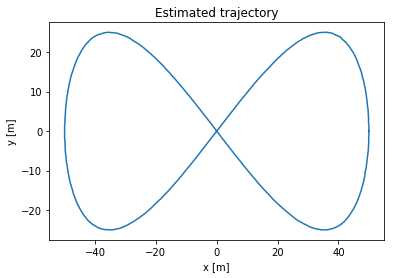

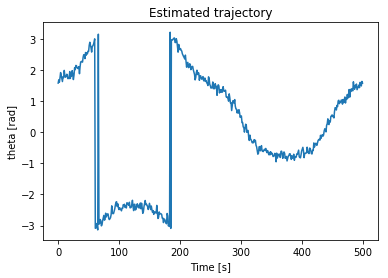

In [52]:
e_fig = plt.figure()
ax = e_fig.add_subplot(111)
ax.plot(x_est[:, 0], x_est[:, 1])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Estimated trajectory')
plt.show()

e_fig = plt.figure()
ax = e_fig.add_subplot(111)
ax.plot(t[:], x_est[:, 2])
ax.set_xlabel('Time [s]')
ax.set_ylabel('theta [rad]')
ax.set_title('Estimated trajectory')
plt.show()

Are you satisfied wth your results? The resulting trajectory should closely resemble the ground truth, with minor "jumps" in the orientation estimate due to angle wrapping. If this is the case, run the code below to produce your solution file.

In [53]:
with open('submission.pkl', 'wb') as f:
    pickle.dump(x_est, f, pickle.HIGHEST_PROTOCOL)